In [1]:
%cd ..

/home/feodor/Jupyter/depth-poset


/home/feodor/Jupyter/jupyter-env/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import itertools
import inspect
import time
import os

import numpy as np
import pandas as pd
import gudhi as gh
import networkx as nx

from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import matplotlib.lines as mlines

from src import depth
from src.depth import DepthPoset
from src.drow import plot_filtred_complex2d, plot_simplex, enumerate_points

from tqdm import tqdm

# The Simplicial Complex

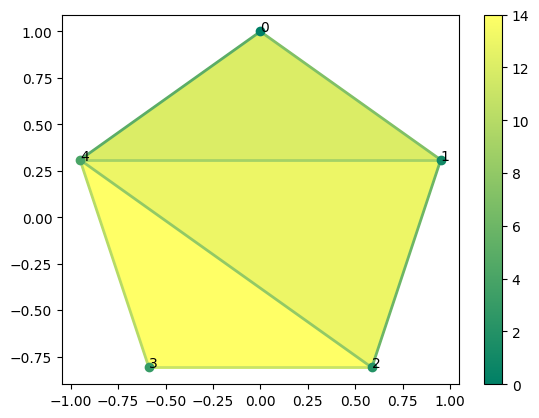

In [3]:
n = 5
points = np.arange(n)*2*np.pi/n
points = np.transpose([np.sin(points), np.cos(points)])

order = [(0, ), (1, ), (2, ), (3, ), (4, ),
         (0, 4), (1, 2), (0, 1), (2, 4), (1, 4), (3, 4), (2, 3), 
         (0, 1, 4), (1, 2, 4), (2, 3, 4)
        ]

stree = gh.SimplexTree()
for value, simplex in enumerate(order):
    stree.insert(simplex, value)


sm = plot_filtred_complex2d(stree, points, cmap='summer')
plt.colorbar(sm, ax=plt.gca())
enumerate_points(points)

plt.show()

# Define and iterate the Transpositions

In [4]:
def order_is_possible(order, backward=False):
    # returns False if there are bigger simplices before the smallest
    if backward:
        #return order_is_possible(np.flip(np.array(order, dtype=object)), backward=False) # Нет. Это не должно так работать...
        for i0 in range(len(order)):
            for i1 in range(i0):
                s0 = np.sort(order[i0])
                s1 = np.sort(order[i1])
                intersection = np.intersect1d(s0, s1)
                if list(s1) == list(intersection):
                    return False
        return True
    for i0 in range(len(order)):
        for i1 in range(i0 + 1, len(order)):
            s0 = np.sort(order[i0])
            s1 = np.sort(order[i1])
            intersection = np.intersect1d(s0, s1)
            if list(s1) == list(intersection):
                return False
    return True

In [5]:
np.flip(np.arange(10))

array([9, 8, 7, 6, 5, 4, 3, 2, 1, 0])

In [6]:
def iterate_possible_transpositions_indices(order, neighbours=True, backward=False):
    # 
    if neighbours:
        generator = np.transpose([np.arange(len(order) - 1), np.arange(len(order) - 1) + 1])
    else:
        generator = itertools.combinations(range(len(order)), 2)
    for i0, i1 in generator:
        new_order = order.copy()
        new_order[i0], new_order[i1] = new_order[i1], new_order[i0]
        if order_is_possible(new_order, backward=backward):
            yield i0, i1

In [7]:
def _get_transposition_type_stree(stree: gh.SimplexTree, s0, s1):
    """
    Returns the type of the transpositon (birth-birth, death-deat, birth-death, another) of 2 simplices: s0 and s1
    """
    s0, s1 = tuple(np.sort(s0)), tuple(np.sort(s1))
    try:
        pairs = stree.persistence_pairs()
    except AssertionError:
        stree.compute_persistence()
        pairs = stree.persistence_pairs() 
    births = [tuple(np.sort(pair[0])) for pair in pairs]
    deaths = [tuple(np.sort(pair[1])) for pair in pairs]
    if s0 in births and s1 in births:
        return 'birth-birth'
    if s0 in deaths and s1 in deaths:
        return 'death-death'
    if s0 in births and s1 in deaths:
        return 'birth-death'
    if s0 in deaths and s1 in births:
        return 'birth-death'

def _get_transposition_type_dp(dp: DepthPoset, s0, s1):
    """
    Returns the type of the transpositon (birth-birth, death-deat, birth-death, another) of 2 simplices: s0 and s1
    """
    s0, s1 = tuple(np.sort(s0)), tuple(np.sort(s1))

    pairs = [node.source for node in dp.nodes]
    
    births = [tuple(np.sort(pair[0])) for pair in pairs]
    deaths = [tuple(np.sort(pair[1])) for pair in pairs]
    if s0 in births and s1 in births:
        return 'birth-birth'
    if s0 in deaths and s1 in deaths:
        return 'death-death'
    if s0 in births and s1 in deaths:
        return 'birth-death'
    if s0 in deaths and s1 in births:
        return 'birth-death'
    # giant cycle rest
    #return 'birth-birth'

def get_transposition_type(arg, s0, s1):
    """
    Returns the type of the transpositon (birth-birth, death-deat, birth-death, another) of 2 simplices: s0 and s1
    """
    if isinstance(arg, gh.SimplexTree):
        return _get_transposition_type_stree(arg, s0, s1)
    if isinstance(arg, DepthPoset):
        return _get_transposition_type_dp(arg, s0, s1)

In [8]:
def _get_transposition_stree(stree: gh.SimplexTree, i0: int, i1: int, order=None):
    # 
    if order is None:
        order = [simplex for simplex, value in stree.get_filtration()]
    return {'index 0': i0, 
            'index 1': i1, 
            'value 0': stree.filtration(order[i0]), 
            'value 1': stree.filtration(order[i1]), 
            'simplex 0': order[i0], 
            'simplex 1': order[i1], 
            'dim 0': len(order[i0]) - 1, 
            'dim 1': len(order[i1]) - 1, 
            'type': get_transposition_type(stree, order[i0], order[i1])
           }
    
def _get_transposition_dp(dp: DepthPoset, i0: int, i1: int, order):
    # 
    return {'index 0': i0, 
            'index 1': i1, 
            'value 0': stree.filtration(order[i0]), 
            'value 1': stree.filtration(order[i1]), 
            'simplex 0': list(np.sort(order[i0])), 
            'simplex 1': list(np.sort(order[i1])), 
            'dim 0': len(order[i0]) - 1, 
            'dim 1': len(order[i1]) - 1, 
            'type': get_transposition_type(dp, order[i0], order[i1])
           }

def _get_transposition_bm(border_matrix: np.array, i0: int, i1: int, order):
    # 
    dims = [len(s) - 1 for s in order]
    dp = DepthPoset.from_border_matrix(border_matrix, dims, sources=order)
    return _get_transposition_dp(dp, i0, i1, order)

def get_transposition(arg, i0: int, i1: int, order=None):
    # 
    if isinstance(arg, gh.SimplexTree):
        return _get_transposition_stree(arg, i0, i1, order)
    if isinstance(arg, np.ndarray):
        return _get_transposition_bm(arg, i0, i1, order)
    if isinstance(arg, DepthPoset):
        return _get_transposition_dp(arg, i0, i1, order)

In [9]:
def _iterate_possible_transpositions_stree(stree: gh.SimplexTree, neighbours=True, transposition_type=None, backward=False):
    # 
    order = [simplex for simplex, value in stree.get_filtration()]
    for i0, i1 in iterate_possible_transpositions_indices(order, neighbours=neighbours, backward=backward):
        transposition = get_transposition(stree, i0, i1, order=order)
        if (transposition_type is None) or (transposition_type == transposition['type']):
            yield transposition

def _iterate_possible_transpositions_dp(dp: DepthPoset, neighbours=True, transposition_type=None, order=None, backward=False):
    # 
    for i0, i1 in iterate_possible_transpositions_indices(order, neighbours=neighbours, backward=backward):
        transposition = get_transposition(dp, i0, i1, order=order)
        if (transposition_type is None) or (transposition_type == transposition['type']):
            yield transposition

def iterate_possible_transpositions(arg, neighbours=True, transposition_type=None, order=None, backward=False):
    # 
    if isinstance(arg, gh.SimplexTree):
        return _iterate_possible_transpositions_stree(arg, neighbours, transposition_type, backward=backward)
    if isinstance(arg, DepthPoset):
        if order is None:
            raise TypeError("iterate_possible_transpositions: missing 1 required positional argument: 'order'")
        return _iterate_possible_transpositions_dp(arg, neighbours, transposition_type, order, backward=backward)
        

In [10]:
timer = time.perf_counter()
df_transpositions = pd.DataFrame(iterate_possible_transpositions(stree))
timer = time.perf_counter() - timer

print(f'Transpositions are found in {timer:.4f} seconds.\n')
print(f'Transposition types distribution:\n{
        '\n'.join(str(df_transpositions['type'].value_counts()).split('\n')[1:-1])
        }\n')

print(f'df_transpositions.shape = {df_transpositions.shape}')
df_transpositions.head()

Transpositions are found in 0.0289 seconds.

Transposition types distribution:
birth-birth    5
death-death    4
birth-death    4

df_transpositions.shape = (13, 9)


,index 0,index 1,value 0,value 1,simplex 0,simplex 1,dim 0,dim 1,type
0,0,1,0.0,1.0,[0],[1],0,0,birth-birth
1,1,2,1.0,2.0,[1],[2],0,0,birth-birth
2,2,3,2.0,3.0,[2],[3],0,0,birth-birth
3,3,4,3.0,4.0,[3],[4],0,0,birth-birth
4,5,6,5.0,6.0,"[0, 4]","[1, 2]",1,1,death-death


In [11]:
timer = time.perf_counter()
order, border_matrix = depth.get_ordered_border_matrix_from_simplex_tree(stree)
dp = DepthPoset.from_simplex_tree(stree)
dp = DepthPoset.from_border_matrix(border_matrix, [len(s) - 1 for s in order], sources=order)
df_transpositions_bm = pd.DataFrame(iterate_possible_transpositions(dp, order=order))
timer = time.perf_counter() - timer

print(f'Transpositions are by border matrix found in {timer:.4f} seconds.\n')
#print(f'Transposition types distribution:\n{
#        '\n'.join(str(df_transpositions_bm['type'].value_counts()).split('\n')[1:-1])
#        }\n')

print(f'df_transpositions_bm.shape = {df_transpositions_bm.shape}')
df_transpositions_bm.head()

Transpositions are by border matrix found in 0.0356 seconds.

df_transpositions_bm.shape = (13, 9)


,index 0,index 1,value 0,value 1,simplex 0,simplex 1,dim 0,dim 1,type
0,0,1,0.0,1.0,[0],[1],0,0,None
1,1,2,1.0,2.0,[1],[2],0,0,birth-birth
2,2,3,2.0,3.0,[2],[3],0,0,birth-birth
3,3,4,3.0,4.0,[3],[4],0,0,birth-birth
4,5,6,5.0,6.0,"[0, 4]","[1, 2]",1,1,death-death


## Plot the Transposition

In [12]:
def plot_transposition(transposition, stree0, stree1, dp0, dp1, points=points, fig=None, axs=None, 
                       figsize=(9, 8), cmap='summer', layout='persistant'):
    # returns fig, axs
    s0 = transposition['simplex 0']
    s1 = transposition['simplex 1']

    if fig is None or axs is None:
        fig, axs = plt.subplots(2, 2, figsize=figsize)
    
    fig.suptitle(f'The {transposition['type'].replace('b', 'B').replace('d', 'D')} Transposition of Simplices {s0} and {s1}')
    axs[0, 0].set_title('Complex before the Transposition')
    axs[0, 1].set_title('Complex after the Transposition')
    axs[1, 0].set_title('Depth Poset before the Transposition')
    axs[1, 1].set_title('Depth Poset after the Transposition')
    
    
    for i, streei in enumerate([stree0, stree1]):
        sm = plot_filtred_complex2d(streei, points, ax=axs[0, i], cmap=cmap, linewidth=4)
        plt.colorbar(sm, ax=axs[0, i])
    
        plot_simplex(s0, points, ax=axs[0, i], color='red', marker='x', linestyle=':', hatch='+', 
                 label=f'f({s0}) = {streei.filtration(s0)}', zorder=4)
        plot_simplex(s1, points, ax=axs[0, i], color='blue', marker='x', linestyle=':', hatch='+', 
                 label=f'f({s1}) = {streei.filtration(s1)}', zorder=4)
        enumerate_points(points, ax=axs[0, i])
        axs[0, i].legend()

    if layout == 'hasse':
        for i, dpi in enumerate([dp0, dp1]):
            node_color = ['gold' if tuple(s0) in node.source or tuple(s1) in node.source else 'teal' for node in dpi.nodes]
            nx.draw_networkx(dpi.get_transitive_reduction(), pos=dpi.hasse_layout(), ax=axs[1, i], 
                             node_color=node_color, node_size=36, 
                             labels=dpi.get_labels(), 
                             with_labels=True, hide_ticks=True)
    elif layout == 'persistant':
        for i, dpi in enumerate([dp0, dp1]):
            node_color = ['gold' if tuple(s0) in node.source or tuple(s1) in node.source else 'teal' for node in dpi.nodes]
            nx.draw_networkx(dpi.get_transitive_reduction(), pos=dpi.persistant_layout(), ax=axs[1, i], 
                             node_color=node_color, node_size=36, 
                             labels=dpi.get_labels(), 
                             with_labels=False, hide_ticks=False)
            axs[1, i].fill_between([0, max(dpi.get_filtration_values())], 
                                   [0, max(dpi.get_filtration_values())], [0, 0], color='lightgrey')
            axs[1, i].set_xlim(*(max(dpi.get_filtration_values())*np.array([-0.05, 1.05])))
            axs[1, i].set_ylim(*(max(dpi.get_filtration_values())*np.array([-0.05, 1.05])))

    return fig, axs

In [13]:
def get_strees(transposition, stree: gh.SimplexTree):
    # returns 2 SimplexTrees, before and after the transposition
    s0, s1 = transposition['simplex 0'], transposition['simplex 1']
    v0, v1 = transposition['value 0'], transposition['value 1']
    stree0 = stree.copy()
    stree1 = stree.copy()
    stree1.assign_filtration(s1, v0)
    stree1.assign_filtration(s0, v1)
    return stree0, stree1

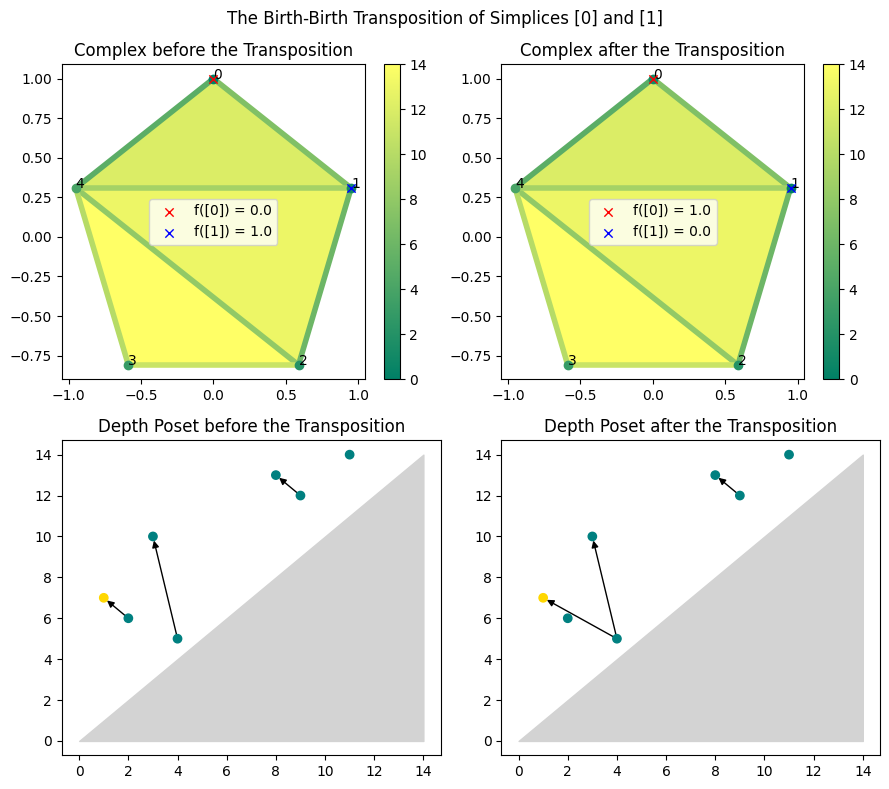

In [14]:
transposition = df_transpositions.loc[np.random.choice(df_transpositions.index)]

stree0, stree1 = get_strees(transposition, stree)

dp0 = DepthPoset.from_simplex_tree(stree0)
dp1 = DepthPoset.from_simplex_tree(stree1)

fig, axs = plot_transposition(transposition, stree0, stree1, dp0, dp1, points=points, cmap='summer')
plt.tight_layout()

plt.show()

## Classifying the Transpositions

In [15]:
def get_xyab_bb(transposition, dp0: DepthPoset):
    # Returns x, y, a, b indices for birth-birth case
    if transposition['type'] != 'birth-birth':
        return None
    for node in dp0.nodes:
        if node.birth_index == transposition['index 0']:
            a = node.birth_index
            b = node.death_index
        if node.birth_index == transposition['index 1']:
            x = node.birth_index
            y = node.death_index
    return x, y, a, b

def get_xyab_dd(transposition, dp0: DepthPoset):
    # Returns x, y, a, b indices for death-death case
    if transposition['type'] != 'death-death':
        return None
    for node in dp0.nodes:
        if node.death_index == transposition['index 0']:
            x = node.birth_index
            y = node.death_index
        if node.death_index == transposition['index 1']:
            a = node.birth_index
            b = node.death_index
    return x, y, a, b

def get_xyab_bd(transposition, dp0: DepthPoset):
    # Returns x, y, a, b indices for birth-death case
    if transposition['type'] != 'birth-death':
        return None
    for node in dp0.nodes:
        if node.death_index == transposition['index 0']:
            a = node.birth_index
            b = node.death_index
        if node.death_index == transposition['index 1']:
            a = node.birth_index
            b = node.death_index
        if node.birth_index == transposition['index 0']:
            x = node.birth_index
            y = node.death_index
        if node.birth_index == transposition['index 1']:
            x = node.birth_index
            y = node.death_index
    return x, y, a, b
    
def get_xyab(transposition, dp0: DepthPoset):
    # 
    try:
        if transposition['type'] == 'birth-birth':
            return get_xyab_bb(transposition, dp0)
        if transposition['type'] == 'death-death':
            return get_xyab_dd(transposition, dp0)
        if transposition['type'] == 'birth-death':
            return get_xyab_bd(transposition, dp0)
    except UnboundLocalError:
        return None

In [16]:
df_transpositions['xyab'] = [get_xyab(transposition, dp0) for i, transposition in df_transpositions.iterrows()]

assert df_transpositions['xyab'].isna().sum() == 1

print(f'df_transpositions.shape = {df_transpositions.shape}')
df_transpositions.head()

df_transpositions.shape = (13, 10)


,index 0,index 1,value 0,value 1,simplex 0,simplex 1,dim 0,dim 1,type,xyab
0,0,1,0.0,1.0,[0],[1],0,0,birth-birth,None
1,1,2,1.0,2.0,[1],[2],0,0,birth-birth,"(2, 6, 1, 7)"
2,2,3,2.0,3.0,[2],[3],0,0,birth-birth,"(3, 10, 2, 6)"
3,3,4,3.0,4.0,[3],[4],0,0,birth-birth,"(4, 5, 3, 10)"
4,5,6,5.0,6.0,"[0, 4]","[1, 2]",1,1,death-death,"(4, 5, 2, 6)"


In [17]:
df_transpositions_bm['xyab'] = [get_xyab(transposition, dp0) for i, transposition in df_transpositions.iterrows()]

assert df_transpositions_bm['xyab'].isna().sum() == 1

print(f'df_transpositions_bm.shape = {df_transpositions_bm.shape}')
df_transpositions_bm.head()

df_transpositions_bm.shape = (13, 10)


,index 0,index 1,value 0,value 1,simplex 0,simplex 1,dim 0,dim 1,type,xyab
0,0,1,0.0,1.0,[0],[1],0,0,None,None
1,1,2,1.0,2.0,[1],[2],0,0,birth-birth,"(2, 6, 1, 7)"
2,2,3,2.0,3.0,[2],[3],0,0,birth-birth,"(3, 10, 2, 6)"
3,3,4,3.0,4.0,[3],[4],0,0,birth-birth,"(4, 5, 3, 10)"
4,5,6,5.0,6.0,"[0, 4]","[1, 2]",1,1,death-death,"(4, 5, 2, 6)"


In [18]:
def _get_transposition_relations_and_classifying_matrix_stree(stree0: gh.SimplexTree, dp0: DepthPoset, transposition, reduce_matrix=True):
    # 
    order0, border_matrix0 = depth.get_ordered_border_matrix_from_simplex_tree(stree0)
    try:
        x, y, a, b = get_xyab(transposition, dp0)
    except TypeError:
        return None, None, None

    stop_condition = lambda alpha, b0, delta: len({(a, b), (a, y), (x, b), (x, y)} & set(alpha.values())) + \
                                              len({(a, x), (x, a), (b, y), (y, b)} & set(b0)) > 0
    if transposition['type'] == 'birth-birth':
        #stop_condition = lambda alpha, b0, delta0: len({(a, b), (a, y), (x, b), (x, y)} & set(alpha.values())) + len({(b, y), (y, b)} & set (b0)) != 0
        alpha, b0, delta0 = depth.reduct_column_bottom_to_top(border_matrix0, stop_condition)
        if reduce_matrix:
            return list(alpha.values()), b0, tuple(map(tuple, delta0[np.sort([x, a])][:, np.sort([y, b])]))
        else:
            return list(alpha.values()), b0, delta0
            
    if transposition['type'] == 'death-death':
        #stop_condition = lambda omega, b1, delta1: len({(a, b), (a, y), (x, b), (x, y)} & set(omega.values())) + len({(a, x), (x, a)} & set (b1)) != 0
        omega, b1, delta1 = depth.reduct_row_left_to_right(border_matrix0, stop_condition)
        if reduce_matrix:
            return list(omega.values()), b1, tuple(map(tuple, delta1[np.sort([x, a])][:, np.sort([y, b])]))
        else:
            return list(omega.values()), b1, delta1
        
    if transposition['type'] == 'birth-death':
        #stop_condition = lambda alpha, b0, delta0: len({(a, b), (a, y), (x, b), (x, y)} & set(alpha.values())) + len({(b, y), (y, b)} & set (b0)) != 0
        alpha, b0, delta0 = depth.reduct_column_bottom_to_top(border_matrix0, stop_condition)
        #stop_condition = lambda omega, b1, delta1: len({(a, b), (a, y), (x, b), (x, y)} & set(omega.values())) + len({(a, x), (x, a)} & set (b1)) != 0
        omega, b1, delta1 = depth.reduct_row_left_to_right(delta0, stop_condition)
        if reduce_matrix:
            return list(alpha.values()) + list(omega.values()), b0 + b1, tuple(map(tuple, delta1[np.sort([a, b, x, y])][:, np.sort([a, b, x, y])]))
        else:
            return list(alpha.values()) + list(omega.values()), b0 + b1, delta1


def _get_transposition_relations_and_classifying_matrix_bm(border_matrix0: np.ndarray, dp0: DepthPoset, transposition, reduce_matrix=True, order0=None):
    # 
    if order0 is None:
        order0 = np.arange(len(border_matrix0))
    try:
        x, y, a, b = get_xyab(transposition, dp0)
    except TypeError:
        return None, None, None

    stop_condition = lambda alpha, b0, delta: len({(a, b), (a, y), (x, b), (x, y)} & set(alpha.values())) + \
                                              len({(a, x), (x, a), (b, y), (y, b)} & set(b0)) > 0
    if transposition['type'] == 'birth-birth':
        #stop_condition = lambda alpha, b0, delta0: len({(a, b), (a, y), (x, b), (x, y)} & set(alpha.values())) + len({(b, y), (y, b)} & set (b0)) != 0
        alpha, b0, delta0 = depth.reduct_column_bottom_to_top(border_matrix0, stop_condition)
        if reduce_matrix:
            return list(alpha.values()), b0, tuple(map(tuple, delta0[np.sort([x, a])][:, np.sort([y, b])]))
        else:
            return list(alpha.values()), b0, delta0
            
    if transposition['type'] == 'death-death':
        #stop_condition = lambda omega, b1, delta1: len({(a, b), (a, y), (x, b), (x, y)} & set(omega.values())) + len({(a, x), (x, a)} & set (b1)) != 0
        omega, b1, delta1 = depth.reduct_row_left_to_right(border_matrix0, stop_condition)
        if reduce_matrix:
            return list(omega.values()), b1, tuple(map(tuple, delta1[np.sort([x, a])][:, np.sort([y, b])]))
        else:
            return list(omega.values()), b1, delta1
        
    if transposition['type'] == 'birth-death':
        #stop_condition = lambda alpha, b0, delta0: len({(a, b), (a, y), (x, b), (x, y)} & set(alpha.values())) + len({(b, y), (y, b)} & set (b0)) != 0
        alpha, b0, delta0 = depth.reduct_column_bottom_to_top(border_matrix0, stop_condition)
        #stop_condition = lambda omega, b1, delta1: len({(a, b), (a, y), (x, b), (x, y)} & set(omega.values())) + len({(a, x), (x, a)} & set (b1)) != 0
        omega, b1, delta1 = depth.reduct_row_left_to_right(delta0, stop_condition)
        if reduce_matrix:
            return list(alpha.values()) + list(omega.values()), b0 + b1, tuple(map(tuple, delta1[np.sort([a, b, x, y])][:, np.sort([a, b, x, y])]))
        else:
            return list(alpha.values()) + list(omega.values()), b0 + b1, delta1

def get_transposition_relations_and_classifying_matrix(arg, dp0: DepthPoset, transposition, reduce_matrix=True, order=None):
    # 
    if isinstance(arg, gh.SimplexTree):
        return _get_transposition_relations_and_classifying_matrix_stree(arg, dp0, transposition, reduce_matrix)
    if isinstance(arg, np.ndarray):
        return _get_transposition_relations_and_classifying_matrix_bm(arg, dp0, transposition, reduce_matrix, order)

In [19]:
(df_transpositions['bd-pairs'], 
 df_transpositions['relations'], 
 df_transpositions['classifying matrix']) = zip(*[get_transposition_relations_and_classifying_matrix(stree0, dp0, transposition) for i, transposition in df_transpositions.iterrows()])


assert df_transpositions['relations'].isna().sum() == 1
assert df_transpositions['classifying matrix'].isna().sum() == 1

print(f'df_transpositions.shape = {df_transpositions.shape}')
df_transpositions.head()

df_transpositions.shape = (13, 13)


,index 0,index 1,value 0,value 1,simplex 0,simplex 1,dim 0,dim 1,type,xyab,bd-pairs,relations,classifying matrix
0,0,1,0.0,1.0,[0],[1],0,0,birth-birth,None,None,None,None
1,1,2,1.0,2.0,[1],[2],0,0,birth-birth,"(2, 6, 1, 7)","[(11, 14), (9, 12), (8, 13), (4, 5), (3, 10), ...","[(12, 13), (5, 10)]","((1, 1), (1, 0))"
2,2,3,2.0,3.0,[2],[3],0,0,birth-birth,"(3, 10, 2, 6)","[(11, 14), (9, 12), (8, 13), (4, 5), (3, 10)]","[(12, 13), (5, 10)]","((1, 0), (0, 1))"
3,3,4,3.0,4.0,[3],[4],0,0,birth-birth,"(4, 5, 3, 10)","[(11, 14), (9, 12), (8, 13), (4, 5)]","[(12, 13), (5, 10)]","((0, 1), (1, 1))"
4,5,6,5.0,6.0,"[0, 4]","[1, 2]",1,1,death-death,"(4, 5, 2, 6)","[(4, 5)]","[(4, 0)]","((0, 1), (1, 0))"


In [20]:
(df_transpositions_bm['bd-pairs'], 
 df_transpositions_bm['relations'], 
 df_transpositions_bm['classifying matrix']) = zip(*[get_transposition_relations_and_classifying_matrix(stree0, dp0, transposition) for i, transposition in df_transpositions_bm.iterrows()])


assert df_transpositions_bm['relations'].isna().sum() == 1
assert df_transpositions_bm['classifying matrix'].isna().sum() == 1

print(f'df_transpositions_bm.shape = {df_transpositions_bm.shape}')
df_transpositions_bm

cond = lambda df0, df1: (df0 != df1)&(~(df0.isna()&df1.isna()))
pd.concat([df_transpositions[df_transpositions_bm.columns[cond(df_transpositions_bm, df_transpositions).any(axis=0)]], 
           df_transpositions_bm[df_transpositions_bm.columns[cond(df_transpositions_bm, df_transpositions).any(axis=0)]]
          ], axis=1).head()

df_transpositions_bm.shape = (13, 13)


,type,type
0,birth-birth,None
1,birth-birth,birth-birth
2,birth-birth,birth-birth
3,birth-birth,birth-birth
4,death-death,death-death


In [21]:
def _get_switch_type_stree(stree0: gh.SimplexTree, dp0: DepthPoset, transposition):
    # 
    alpha, omega, matrix = get_transposition_relations_and_classifying_matrix(stree0, dp0, transposition, reduce_matrix=True)

    if transposition['type'] == 'birth-birth':
        if matrix == ((1, 1), 
                      (1, 0)):
            return "switch forward"
        if matrix == ((1, 0), 
                      (1, 1)):
            return "switch backward"
    if transposition['type'] == 'death-death':
        if matrix == ((0, 1), 
                      (1, 1)):
            return "switch forward"
        if matrix == ((1, 0), 
                      (1, 1)):
            return "switch backward"
    if transposition['type'] == 'birth-death':
        if matrix == ((0, 1, 1, 0), 
                      (0, 0, 0, 1), 
                      (0, 0, 0, 1), 
                      (0, 0, 0, 0)):
            return "switch forward"
    return 'no switch'

def _get_switch_type_bm(border_matrix: np.ndarray, dp0: DepthPoset, transposition, order=None):
    # 
    alpha, omega, matrix = get_transposition_relations_and_classifying_matrix(border_matrix, dp0, transposition, reduce_matrix=True, order=order)

    if transposition['type'] == 'birth-birth':
        if matrix == ((1, 1), 
                      (1, 0)):
            return "switch forward"
        if matrix == ((1, 0), 
                      (1, 1)):
            return "switch backward"
    if transposition['type'] == 'death-death':
        if matrix == ((0, 1), 
                      (1, 1)):
            return "switch forward"
        if matrix == ((1, 0), 
                      (1, 1)):
            return "switch backward"
    if transposition['type'] == 'birth-death':
        if matrix == ((0, 1, 1, 0), 
                      (0, 0, 0, 1), 
                      (0, 0, 0, 1), 
                      (0, 0, 0, 0)):
            return "switch forward"
    return 'no switch'

def get_switch_type(arg, dp0: DepthPoset, transposition, order=None):
    # 
    if isinstance(arg, gh.SimplexTree):
        return _get_switch_type_stree(arg, dp0, transposition)
    if isinstance(arg, np.ndarray):
        return _get_switch_type_bm(arg, dp0, transposition, order=order)

In [22]:
df_transpositions['switch'] = df_transpositions.apply(lambda row: get_switch_type(stree0, dp0, row), axis=1)

df_transpositions['switch'].value_counts()

switch
no switch         9
switch forward    4
Name: count, dtype: int64

In [23]:
expected_classifying_matrices = {
    'birth-birth': [((1, 1), 
                     (1, 0)), 
                    ((1, 0), 
                     (1, 1)), 
                    ((0, 1), 
                     (1, 1)), 
                    ((1, 1), 
                     (0, 1)), 
                    ((0, 1), 
                     (1, 0)), 
                    ((1, 0), 
                     (0, 1)),
                    None, 
                   ], 
    'death-death': [((0, 1), 
                     (1, 1)), 
                    ((1, 0), 
                     (1, 1)), 
                    ((1, 1), 
                     (1, 0)), 
                    ((1, 1), 
                     (0, 1)), 
                    ((0, 1), 
                     (1, 0)), 
                    ((1, 0), 
                     (0, 1)), 
                   ],
    'birth-death': [((0, 1, 1, 0), 
                     (0, 0, 0, 1), 
                     (0, 0, 0, 1), 
                     (0, 0, 0, 0)), 
                    ((0, 1, 0, 0), 
                     (0, 0, 0, 0), 
                     (0, 0, 0, 1), 
                     (0, 0, 0, 0)), 
                    ((0, 0, 1, 0), 
                     (0, 0, 0, 1), 
                     (0, 0, 0, 0), 
                     (0, 0, 0, 0)), 
                   ]
}

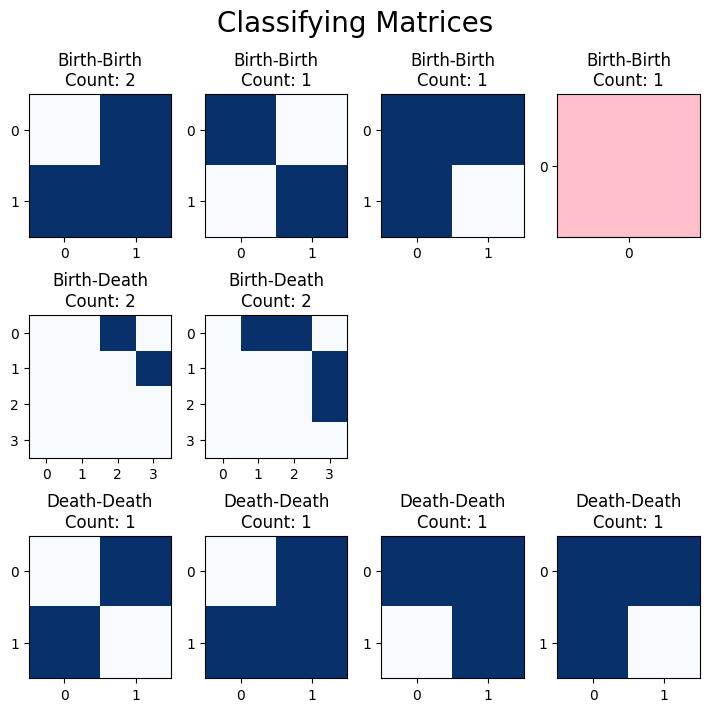

In [24]:
situations = df_transpositions[['type', 'classifying matrix', 'xyab']].fillna('None').rename(columns={'xyab': 'count'})
situations = situations.groupby(['type', 'classifying matrix'], as_index=False).count().replace('None', None)

situations['expected'] = situations.apply(lambda row: row['classifying matrix'] in expected_classifying_matrices[row['type']], axis=1)


n = situations['type'].value_counts().max()
m = len(pd.unique(situations['type']))
fig, axs = plt.subplots(m, n, figsize=(1.8*n, 2.4*m))
fig.suptitle('Classifying Matrices', fontsize=20)

cmap = plt.get_cmap('Blues')
cmap.set_bad(color='pink')

for j, situation_type in enumerate(pd.unique(situations['type'])):
    these_situations = situations[situations['type'] == situation_type].reset_index(drop=True)
    for i, situation in these_situations.iterrows():
        matrix = these_situations.loc[i, 'classifying matrix']
        if matrix is None:
            matrix = np.nan*np.ones([1, 1])
        matrix = np.array(matrix)
        axs[j, i].set_title(f'{situation_type.replace('b', 'B').replace('d', 'D')}\nCount: {situation['count']}', 
                            color='black' if situation['expected'] else 'red')
        axs[j, i].imshow(matrix, cmap=cmap, vmin=0, vmax=1, origin='upper')
        axs[j, i].set_xticks(np.arange(matrix.shape[1]))
        axs[j, i].set_yticks(np.arange(matrix.shape[0]))
    for i in range(len(these_situations), n):
        axs[j, i].set_xticks([])
        axs[j, i].set_yticks([])
        for spine in axs[j, i].spines.values():
            spine.set_visible(False)

plt.tight_layout()
plt.show()

In [25]:
df_transpositions['expected'] = df_transpositions.apply(lambda row: row['classifying matrix'] in expected_classifying_matrices[row['type']], axis=1)

print(f"There are {(~df_transpositions['expected']).sum()} unexpected situations.")


There are 0 unexpected situations.


In [26]:
drow_more = True

for i, transposition in df_transpositions[~df_transpositions['expected']].iterrows():
    stree0, stree1 = get_strees(transposition, stree)

    dp0 = DepthPoset.from_simplex_tree(stree0)
    dp1 = DepthPoset.from_simplex_tree(stree1)

    fig, axs = plt.subplots(5, 2, figsize=(8, 16))
    fig, axs = plot_transposition(transposition, stree0, stree1, dp0, dp1, fig=fig, axs=axs)

    x, y, a, b = get_xyab(transposition, dp0)
    assert (np.sort([x, y, a, b]) == np.sort(get_xyab(transposition, dp1))).all()
    
    lim_min = np.min([x, y, a, b]) - 2
    lim_max = np.max([x, y, a, b]) + 3
    extents = [(lim_min, lim_min), 
               (lim_min, lim_max), 
               (lim_max, lim_min), 
               (lim_max, lim_max), 
              ]

    order0, border_matrix0 = depth.get_ordered_border_matrix_from_simplex_tree(stree0)
    order1, border_matrix1 = depth.get_ordered_border_matrix_from_simplex_tree(stree1)

    axs[2, 0].set_title('Border Matrix before the Transposition')
    axs[2, 1].set_title('Border Matrix after the Transposition')
    axs[2, 0].imshow(border_matrix0, cmap='Blues', origin='upper')
    axs[2, 1].imshow(border_matrix1, cmap='Blues', origin='upper')
    
    stop_condition = lambda alpha, b0, delta: len({(a, b), (a, y), (x, b), (x, y)} & set(alpha.values())) + \
                                              len({(a, x), (x, a), (b, y), (y, b)} & set(b0)) > 0
    alpha0, b00, delta00 = depth.reduct_column_bottom_to_top(border_matrix0, stop_condition)
    alpha1, b01, delta01 = depth.reduct_column_bottom_to_top(border_matrix1, stop_condition)

    axs[3, 0].set_title('Column Reduction before the Transposition')
    axs[3, 1].set_title('Column Reduction after the Transposition')
    axs[3, 0].imshow(delta00, cmap='Blues', origin='upper')
    axs[3, 1].imshow(delta01, cmap='Blues', origin='upper')
    
    omega0, b10, delta10 = depth.reduct_row_left_to_right(border_matrix0, stop_condition)
    omega1, b11, delta11 = depth.reduct_row_left_to_right(border_matrix1, stop_condition)

    axs[4, 0].set_title('Row Reduction before the Transposition')
    axs[4, 1].set_title('Row Reduction after the Transposition')
    axs[4, 0].imshow(delta10, cmap='Blues', origin='upper')
    axs[4, 1].imshow(delta11, cmap='Blues', origin='upper')

    ticks = np.sort([x, y, a, b])
    for j2 in [2, 3, 4]:
        axs[j2, 0].set_xticks(ticks, labels=[f'{tick} d{len(order0[tick]) - 1}' for tick in ticks], rotation=90)
        axs[j2, 0].set_yticks(ticks, labels=[f'{tick} d{len(order0[tick]) - 1}' for tick in ticks], rotation=0)
        axs[j2, 1].set_xticks(ticks, labels=[f'{tick} d{len(order0[tick]) - 1}' for tick in ticks], rotation=90)
        axs[j2, 1].set_yticks(ticks, labels=[f'{tick} d{len(order0[tick]) - 1}' for tick in ticks], rotation=0)
        for j in range(2):
            axs[j2, j].set_xlim(lim_min, lim_max - 1)
            axs[j2, j].set_ylim(lim_min, lim_max - 1)
            axs[j2, j].grid(True)

    plt.tight_layout()
    plt.savefig(f'pics/unexpected_transposition-{i}.png')

    # Show an example only once
    if drow_more:
        plt.show()
        drow_more = False
    else:
        plt.close()

In [27]:
df_transpositions[['type', 'switch']].value_counts().sort_index()

type         switch        
birth-birth  no switch         4
             switch forward    1
birth-death  no switch         2
             switch forward    2
death-death  no switch         3
             switch forward    1
Name: count, dtype: int64

In [28]:
df_transpositions

,index 0,index 1,value 0,value 1,simplex 0,simplex 1,dim 0,dim 1,type,xyab,bd-pairs,relations,classifying matrix,switch,expected
0,0,1,0.0,1.0,[0],[1],0,0,birth-birth,None,None,None,None,no switch,True
1,1,2,1.0,2.0,[1],[2],0,0,birth-birth,"(2, 6, 1, 7)","[(11, 14), (9, 12), (8, 13), (4, 5), (3, 10), ...","[(12, 13), (5, 10)]","((1, 1), (1, 0))",switch forward,True
2,2,3,2.0,3.0,[2],[3],0,0,birth-birth,"(3, 10, 2, 6)","[(11, 14), (9, 12), (8, 13), (4, 5), (3, 10)]","[(12, 13), (5, 10)]","((1, 0), (0, 1))",no switch,True
3,3,4,3.0,4.0,[3],[4],0,0,birth-birth,"(4, 5, 3, 10)","[(11, 14), (9, 12), (8, 13), (4, 5)]","[(12, 13), (5, 10)]","((0, 1), (1, 1))",no switch,True
4,5,6,5.0,6.0,"[0, 4]","[1, 2]",1,1,death-death,"(4, 5, 2, 6)","[(4, 5)]","[(4, 0)]","((0, 1), (1, 0))",no switch,True
5,6,7,6.0,7.0,"[1, 2]","[0, 1]",1,1,death-death,"(2, 6, 1, 7)","[(4, 5), (2, 6)]","[(4, 0), (2, 1)]","((1, 1), (1, 0))",no switch,True
6,7,8,7.0,8.0,"[0, 1]","[2, 4]",1,1,birth-death,"(8, 13, 1, 7)","[(11, 14), (9, 12), (8, 13), (4, 5), (2, 6), (...","[(12, 13), (4, 0), (2, 1), (1, 0)]","((0, 1, 1, 0), (0, 0, 0, 1), (0, 0, 0, 1), (0,...",switch forward,True
7,8,9,8.0,9.0,"[2, 4]","[1, 4]",1,1,birth-birth,"(9, 12, 8, 13)","[(11, 14), (9, 12)]","[(12, 13)]","((0, 1), (1, 1))",no switch,True
8,9,10,9.0,10.0,"[1, 4]","[3, 4]",1,1,birth-death,"(9, 12, 3, 10)","[(11, 14), (9, 12), (4, 5), (2, 6), (1, 7), (3...","[(12, 13), (4, 0), (2, 1), (1, 0), (3, 0)]","((0, 0, 1, 0), (0, 0, 0, 1), (0, 0, 0, 0), (0,...",no switch,True
9,10,11,10.0,11.0,"[3, 4]","[2, 3]",1,1,birth-death,"(11, 14, 3, 10)","[(11, 14), (4, 5), (2, 6), (1, 7), (3, 10)]","[(4, 0), (2, 1), (1, 0), (3, 0)]","((0, 1, 1, 0), (0, 0, 0, 1), (0, 0, 0, 1), (0,...",switch forward,True


# Basic Set Difference Measures

In [29]:
def jacard_index(a, b):
    """
    Calculate the Jaccard index
    """
    intersection = set(a) & set(b)
    union = set(a) | set(b)
    if len(union) == 0:
        return 1.0
    return len(intersection) / len(union)

# Lemmas and Hypothesises

Write $\text{Succ}(s, t) = \text{Succ}'(s, t) = \text{Succ}''(s, t)$ for the succesors and $\text{Pred}(s, t) = \text{Pred}'(s, t) = \text{Pred}''(s, t)$ for the predecessors (ancessors) of the pair in $D$, $D'$, $D''$, respectively.

Since $D = D' \cup D''$, we also have $\text{Succ}(s, t) = \text{Succ}'(s, t) \cup \text{Succ}''(s, t)$ and $\text{Pred}(s, t) = \text{Pred}'(s, t) \cup \text{Pred}''(s, t)$.

## Lemma 3.1.
Suppose $(x, y)$ and $(a, b)$ are birth-death pairs of $f: X\to R$, $a, x$ are consecutive in the ordering of the cellls by $f$, and the transposition $a, x$ is a switch. Then
$$
\text{Succ}'(a, y) = \{(x, b)\} \cup \text{Succ}'(a, b) \cup \{(s, t)\in \text{Succ}'(x, y) | f(t)<f(b)\}
$$
$$
\text{Succ}'(x, b) = \{(s, t)\in \text{Succ}'(x, y) \oplus \text{Succ}'(a, b) | f(t) > f(b)\}
$$


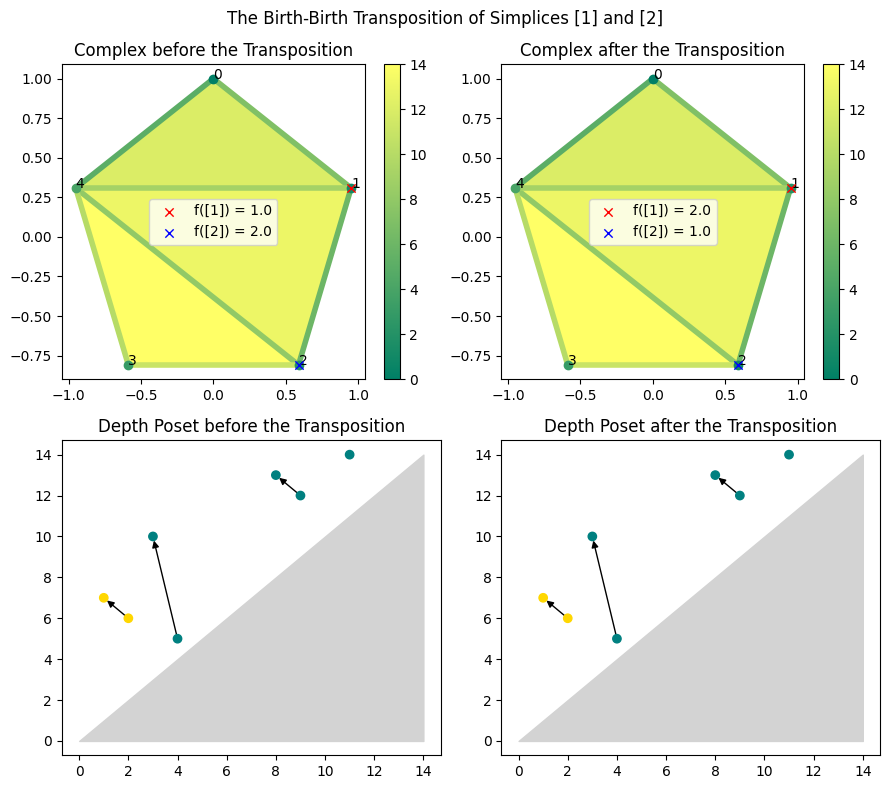

,forward,backward
bd-pairs,"[(11, 14), (9, 12), (8, 13), (4, 5), (3, 10), ...","[(11, 14), (9, 12), (8, 13), (4, 5), (3, 10), ..."
classifying matrix,"((1, 1), (1, 0))","((1, 0), (1, 1))"
dim 0,0,0
dim 1,0,0
expected,True,NaN
index 0,1,1
index 1,2,2
relations,"[(12, 13), (5, 10)]","[(12, 13), (5, 10), (6, 7)]"
simplex 0,[1],[2]
simplex 1,[2],[1]


In [30]:
transposition = df_transpositions.loc[np.random.choice(df_transpositions[(df_transpositions['type'] == 'birth-birth') &
                                                                         (df_transpositions['switch'] != 'no switch')].index)]
#transposition = df_transpositions.loc[6]

stree0, stree1 = get_strees(transposition, stree)

if transposition['switch'] == 'switch backward':
    print("'switch backward' will be reformated to 'switch forward'")
    transposition = pd.Series(get_transposition(stree1, transposition['index 0'], transposition['index 1']))
    stree0, stree1 = get_strees(transposition, stree1)

dp0 = DepthPoset.from_simplex_tree(stree0)
dp1 = DepthPoset.from_simplex_tree(stree1)

try:
    assert transposition['switch'] == get_switch_type(stree0, dp0, transposition)
except KeyError:
    transposition['switch'] = get_switch_type(stree0, dp0, transposition)
    forward_bd_pairs, forward_relations, forward_classifying_matrix = get_transposition_relations_and_classifying_matrix(stree0, dp0, transposition)
    transposition['bd-pairs'] = forward_bd_pairs
    transposition['classifying matrix'] = forward_classifying_matrix
    transposition['relations'] = forward_relations    
    transposition['xyab'] = get_xyab(transposition, dp0)

    
transposition_backward = pd.Series(get_transposition(stree1, transposition['index 0'], transposition['index 1']))
transposition_backward['switch'] = get_switch_type(stree1, dp1, transposition_backward)

backward_bd_pairs, backward_relations, backward_classifying_matrix = get_transposition_relations_and_classifying_matrix(stree1, dp1, transposition_backward)
transposition_backward['bd-pairs'] = backward_bd_pairs
transposition_backward['classifying matrix'] = backward_classifying_matrix
transposition_backward['relations'] = backward_relations

transposition_backward['xyab'] = get_xyab(transposition_backward, dp1)



fig, axs = plot_transposition(transposition, stree0, stree1, dp0, dp1, cmap='summer')
plt.tight_layout()
plt.show()


pd.DataFrame({'forward': transposition, 
              'backward': transposition_backward})

Let's denote the sets from Lemma:
1. $\text{Succ}'(a, y)$ - __l31_set0__
2. $\{(x, b)\}$ - __l31_set1__
3. $\text{Succ}'(a, b)$ - __l31_set2__
4. $\{(s, t)\in \text{Succ}'(x, y) | f(t)<f(b)\}$ - __l31_set3__
5. $\text{Succ}'(x, b)$ - __l31_set4__
6. $\{(s, t)\in \text{Succ}'(x, y) | f(t) > f(b)\}$ - __l31_set5__

Now the Lemma 3.1 will be look like
$$
    \textbf{l31\_set0} = \textbf{l31\_set1} \cup \textbf{l31\_set2} \cup \textbf{l31\_set3} 
$$
$$
    \textbf{l31\_set4} = \textbf{l31\_set5}
$$

In [31]:
def l31_set0(order0, border_matrix0, dp0: DepthPoset, dp1: DepthPoset, transposition):
    r"""
    $
    \text{Succ}'(a, y)
    $
    """
    x, y, a, b = get_xyab(transposition, dp0)
    sx, sy, sa, sb = np.array(order0, dtype=object)[[x, y, a, b]]
    
    node_ay = [node for node in dp1.nodes if node.source[0] == sa and node.source[1] == sy][0]

    poset = dp1.get_column_bottom_to_top_reduction()
    node_condition = lambda other: poset.higher(other, node_ay) and (other != node_ay)
    poset = poset.subposet(node_condition)

    return [node.source for node in poset.nodes]

def l31_set1(order0, border_matrix0, dp0, dp1, transposition):
    r"""
    $
    \{(x, b)\}
    $
    """
    x, y, a, b = get_xyab(transposition, dp0)
    sx, sy, sa, sb = np.array(order0, dtype=object)[[x, y, a, b]]

    return [(sx, sb)]

def l31_set2(order0, border_matrix0, dp0, dp1, transposition):
    r"""
    $
    \text{Succ}'(a, b)
    $
    """
    x, y, a, b = get_xyab(transposition, dp0)
    sx, sy, sa, sb = np.array(order0, dtype=object)[[x, y, a, b]]
    
    node_ab = [node for node in dp0.nodes if node.source[0] == sa and node.source[1] == sb][0]

    poset = dp0.get_column_bottom_to_top_reduction()
    node_condition = lambda other: poset.higher(other, node_ab) and (other != node_ab)
    poset = poset.subposet(node_condition)

    return [node.source for node in poset.nodes]

def l31_set3(order0, border_matrix0, dp0, dp1, transposition):
    r"""
    $
    \{(s, t)\in \text{Succ}'(x, y) | f(t) < f(b)\}
    $
    """
    x, y, a, b = get_xyab(transposition, dp0)
    sx, sy, sa, sb = np.array(order0, dtype=object)[[x, y, a, b]]

    node_xy = [node for node in dp0.nodes if node.source[0] == sx and node.source[1] == sy][0]

    poset = dp0.get_column_bottom_to_top_reduction()
    node_condition = lambda other: poset.higher(other, node_xy) and (other != node_xy)
    succ_xy = poset.subposet(node_condition).nodes
    
    res = [node.source for node in succ_xy if node.death_index < b]
    return res 

In [32]:
def jacard_l31a(order0, border_matrix0, dp0, dp1, transposition):
    r"""
    Jacard Index of $\text{Succ}'(x, b)$ and $\{(a, y)\} \cup \text{Succ}'(a, b) \cup \{(s, t)\in \text{Succ}'(x, y) | f(t) < f(b)\}$
    """
    set0 = l31_set0(order0, border_matrix0, dp0, dp1, transposition)
    set1 = []
    set1 += l31_set1(order0, border_matrix0, dp0, dp1, transposition)
    set1 += l31_set2(order0, border_matrix0, dp0, dp1, transposition)
    set1 += l31_set3(order0, border_matrix0, dp0, dp1, transposition)
    return jacard_index(set0, set1)

In [33]:
order0, border_matrix0 = depth.get_ordered_border_matrix_from_simplex_tree(stree0)

for fl in [l31_set0, l31_set1, l31_set2, l31_set3]:
    seti = fl(order0, border_matrix0, dp0, dp1, transposition)
    print(fl.__name__, ':', seti)

jacard_l31a(order0, border_matrix0, dp0, dp1, transposition)

l31_set0 : [((2,), (0, 1))]
l31_set1 : [((2,), (0, 1))]
l31_set2 : []
l31_set3 : []


1.0

In [34]:
def l31_set4(order0, border_matrix0, dp0, dp1, transposition):
    r"""
    $
    \text{Succ}'(x, b)
    $
    """
    x, y, a, b = get_xyab(transposition, dp0)
    sx, sy, sa, sb = np.array(order0, dtype=object)[[x, y, a, b]]

    node_xb = [node for node in dp1.nodes if node.source[0] == sx and node.source[1] == sb][0]

    poset = dp1.get_column_bottom_to_top_reduction()
    node_condition = lambda other: poset.higher(other, node_xb) and (other != node_xb)
    poset = poset.subposet(node_condition)

    return [node.source for node in poset.nodes]

def l31_set5(order0, border_matrix0, dp0, dp1, transposition):
    r"""
    $
    % \{(s, t)\in \text{Succ}'(x, y) \oplus \text{Succ}'(a, b) | f(b) < f(t)\}
    \{(s, t)\in \text{Succ}'(x, y) \cup \text{Succ}'(a, b) | f(b) < f(t)\}
    $
    """
    #order0, border_matrix0 = depth.get_ordered_border_matrix_from_simplex_tree(stree0)
    
    x, y, a, b = get_xyab(transposition, dp0)
    sx, sy, sa, sb = np.array(order0, dtype=object)[[x, y, a, b]]

    node_xy = [node for node in dp0.nodes if node.source[0] == sx and node.source[1] == sy][0]
    node_ab = [node for node in dp0.nodes if node.source[0] == sa and node.source[1] == sb][0]

    poset = dp0.get_column_bottom_to_top_reduction()
    node_condition_xy = lambda other: poset.higher(other, node_xy) and (other != node_xy)
    node_condition_ab = lambda other: poset.higher(other, node_ab) and (other != node_ab)
    succ_xy = [node.source for node in poset.subposet(node_condition_xy).nodes]
    succ_ab = [node.source for node in poset.subposet(node_condition_ab).nodes]
    #print(f'succ_xy = succ({node_xy}): {succ_xy}')
    #print(f'succ_ab = succ({node_ab}): {succ_ab}')

    
    #res = [node for node in succ_xy if node not in succ_ab] + [node for node in succ_ab if node not in succ_xy]
    res = succ_xy + succ_ab
    #res = [node for node in res if stree0.filtration(node[1]) > b]
    res = [node for node in res if list(order0).index(node[1]) > b]
    
    return res 

In [35]:
def jacard_l31b(order0, border_matrix0, dp0, dp1, transposition):
    r"""
    % Jacard Index of $\text{Succ}'(x, b)$ and $\{(s, t)\in \text{Succ}'(x, y) \oplus \text{Succ}'(a, b) | f(t) > f(b)\}$
    Jacard Index of $\text{Succ}'(x, b)$ and $\{(s, t)\in \text{Succ}'(x, y) \cup \text{Succ}'(a, b) | f(t) > f(b)\}$
    """
    set0 = l31_set4(order0, border_matrix0, dp0, dp1, transposition)
    set1 = l31_set5(order0, border_matrix0, dp0, dp1, transposition)
    return jacard_index(set0, set1)

In [36]:
order0, border_matrix0 = depth.get_ordered_border_matrix_from_simplex_tree(stree0)

for fl in [l31_set4, l31_set5]:
    seti = fl(order0, border_matrix0, dp0, dp1, transposition)
    print(fl.__name__, ':', seti)

jacard_l31b(order0, border_matrix0, dp0, dp1, transposition)

l31_set4 : []
l31_set5 : []


1.0

## Lemma 3.2.
Suppose $(a, b)$ and $(x, y)$ are birth-death pairs of $f:X\to R$, $y, b$ are consecutive in the ordering by $f$, and transposition of $y, b$ is a switch. Then
$$
\text{Succ}''(x, b) = \{(a, y)\} \cup \text{Succ}''(a, b) \cup \{(s, t)\in \text{Succ}''(x, y) | f(a) < f(s)\}
$$
$$
\text{Succ}''(a, y) = \{(s, t)\in\text{Succ}''(x, y) | f(s) < f(a)\}
$$


In [37]:
transposition = df_transpositions.loc[np.random.choice(df_transpositions[(df_transpositions['type'] == 'death-death') &
                                                                         (df_transpositions['switch'] != 'no switch')].index)]

stree0, stree1 = get_strees(transposition, stree)

if transposition['switch'] == 'switch backward':
    print("'switch backward' will be reformated to 'switch forward'")
    transposition = pd.Series(get_transposition(stree1, transposition['index 0'], transposition['index 1']))
    stree0, stree1 = get_strees(transposition, stree1)

dp0 = DepthPoset.from_simplex_tree(stree0)
dp1 = DepthPoset.from_simplex_tree(stree1)

try:
    assert transposition['switch'] == get_switch_type(stree0, dp0, transposition)
except KeyError:
    transposition['switch'] = get_switch_type(stree0, dp0, transposition)
    forward_bd_pairs, forward_relations, forward_classifying_matrix = get_transposition_relations_and_classifying_matrix(stree0, dp0, transposition)
    transposition['bd-pairs'] = forward_bd_pairs
    transposition['classifying matrix'] = forward_classifying_matrix
    transposition['relations'] = forward_relations    
    transposition['xyab'] = get_xyab(transposition, dp0)

    
transposition_backward = pd.Series(get_transposition(stree1, transposition['index 0'], transposition['index 1']))
transposition_backward['switch'] = get_switch_type(stree1, dp1, transposition_backward)

backward_bd_pairs, backward_relations, backward_classifying_matrix = get_transposition_relations_and_classifying_matrix(stree1, dp1, transposition_backward)
transposition_backward['bd-pairs'] = backward_bd_pairs
transposition_backward['classifying matrix'] = backward_classifying_matrix
transposition_backward['relations'] = backward_relations

transposition_backward['xyab'] = get_xyab(transposition_backward, dp1)


pd.DataFrame({'forward': transposition, 
              'backward': transposition_backward})

,forward,backward
bd-pairs,"[(4, 5), (2, 6), (1, 7), (3, 10), (9, 12)]","[(4, 5), (2, 6), (1, 7), (3, 10), (9, 12)]"
classifying matrix,"((0, 1), (1, 1))","((1, 0), (1, 1))"
dim 0,2,2
dim 1,2,2
expected,True,NaN
index 0,12,12
index 1,13,13
relations,"[(4, 0), (2, 1), (1, 0), (3, 0)]","[(4, 0), (2, 1), (1, 0), (3, 0), (9, 8)]"
simplex 0,"[0, 1, 4]","[1, 2, 4]"
simplex 1,"[1, 2, 4]","[0, 1, 4]"


Let's denote these sets:
1. $\text{Succ}''(x, b)$ - __l32_set0__
2. $\{(a, y)\}$ - __l32_set1__
3. $\text{Succ}''(a, b)$ - __l32_set2__
4. $\{(s, t)\in \text{Succ}''(x, y) | f(a) < f(s)\}$ - __l32_set3__
5. $\text{Succ}''(a, y)$ - __l32_set4__
6. $\{(s, t)\in \text{Succ}''(x, y) | f(s) < f(a)\}$ - __l32_set5__

Now the Lemma 3.2 will be look like
$$
    \textbf{l32\_set0} = \textbf{l32\_set1} \cup \textbf{l32\_set2} \cup \textbf{l32\_set3} 
$$
$$
    \textbf{l32\_set4} = \textbf{l32\_set5}
$$

In [38]:
transposition = df_transpositions.loc[np.random.choice(df_transpositions[(df_transpositions['type'] == 'death-death') &
                                                                         (df_transpositions['switch'] != 'no switch')].index)]

stree0, stree1 = get_strees(transposition, stree)

if transposition['switch'] == 'switch backward':
    print("'switch backward' will be reformated to 'switch forward'")
    transposition = pd.Series(get_transposition(stree1, transposition['index 0'], transposition['index 1']))
    stree0, stree1 = get_strees(transposition, stree1)

dp0 = DepthPoset.from_simplex_tree(stree0)
dp1 = DepthPoset.from_simplex_tree(stree1)

try:
    assert transposition['switch'] == get_switch_type(stree0, dp0, transposition)
except KeyError:
    transposition['switch'] = get_switch_type(stree0, dp0, transposition)
    forward_bd_pairs, forward_relations, forward_classifying_matrix = get_transposition_relations_and_classifying_matrix(stree0, dp0, transposition)
    transposition['bd-pairs'] = forward_bd_pairs
    transposition['classifying matrix'] = forward_classifying_matrix
    transposition['relations'] = forward_relations    
    transposition['xyab'] = get_xyab(transposition, dp0)

    
transposition_backward = pd.Series(get_transposition(stree1, transposition['index 0'], transposition['index 1']))
transposition_backward['switch'] = get_switch_type(stree1, dp1, transposition_backward)

backward_bd_pairs, backward_relations, backward_classifying_matrix = get_transposition_relations_and_classifying_matrix(stree1, dp1, transposition_backward)
transposition_backward['bd-pairs'] = backward_bd_pairs
transposition_backward['classifying matrix'] = backward_classifying_matrix
transposition_backward['relations'] = backward_relations

transposition_backward['xyab'] = get_xyab(transposition_backward, dp1)


pd.DataFrame({'forward': transposition, 
              'backward': transposition_backward})

,forward,backward
bd-pairs,"[(4, 5), (2, 6), (1, 7), (3, 10), (9, 12)]","[(4, 5), (2, 6), (1, 7), (3, 10), (9, 12)]"
classifying matrix,"((0, 1), (1, 1))","((1, 0), (1, 1))"
dim 0,2,2
dim 1,2,2
expected,True,NaN
index 0,12,12
index 1,13,13
relations,"[(4, 0), (2, 1), (1, 0), (3, 0)]","[(4, 0), (2, 1), (1, 0), (3, 0), (9, 8)]"
simplex 0,"[0, 1, 4]","[1, 2, 4]"
simplex 1,"[1, 2, 4]","[0, 1, 4]"


In [39]:
def l32_set0(order0, border_matrix0, dp0: DepthPoset, dp1: DepthPoset, transposition):
    r"""
    $
    \text{Succ}''(x, b)
    $
    """
    #order0, border_matrix0 = depth.get_ordered_border_matrix_from_simplex_tree(stree0)
    
    x, y, a, b = get_xyab(transposition, dp0)
    sx, sy, sa, sb = np.array(order0, dtype=object)[[x, y, a, b]]

    node_xb = [node for node in dp1.nodes if node.source[0] == sx and node.source[1] == sb][0]

    poset = dp1.get_row_left_to_right_reduction()
    node_condition = lambda other: poset.higher(other, node_xb) and other != node_xb
    poset = poset.subposet(node_condition)

    return [node.source for node in poset.nodes]

def l32_set1(order0, border_matrix0, dp0, dp1, transposition):
    r"""
    $
    \{(a, y)\}
    $
    """
    #order0, border_matrix0 = depth.get_ordered_border_matrix_from_simplex_tree(stree0)
    
    x, y, a, b = get_xyab(transposition, dp0)
    sx, sy, sa, sb = np.array(order0, dtype=object)[[x, y, a, b]]

    return [(sa, sy)]

def l32_set2(order0, border_matrix0, dp0, dp1, transposition):
    r"""
    $
    \text{Succ}''(a, b)
    $
    """
    #order0, border_matrix0 = depth.get_ordered_border_matrix_from_simplex_tree(stree0)
    
    x, y, a, b = get_xyab(transposition, dp0)
    sx, sy, sa, sb = np.array(order0, dtype=object)[[x, y, a, b]]

    node_ab = [node for node in dp0.nodes if node.source[0] == sa and node.source[1] == sb][0]

    poset = dp0.get_row_left_to_right_reduction()
    node_condition = lambda other: poset.higher(other, node_ab) and other != node_ab
    poset = poset.subposet(node_condition)

    return [node.source for node in poset.nodes]

def l32_set3(order0, border_matrix0, dp0, dp1, transposition):
    r"""
    $
    \{(s, t)\in \text{Succ}''(x, y) | f(a) < f(s) \}
    $
    """
    #order0, border_matrix0 = depth.get_ordered_border_matrix_from_simplex_tree(stree0)
    
    x, y, a, b = get_xyab(transposition, dp0)
    sx, sy, sa, sb = np.array(order0, dtype=object)[[x, y, a, b]]

    node_xy = [node for node in dp0.nodes if node.source[0] == sx and node.source[1] == sy][0]

    poset = dp0.get_row_left_to_right_reduction()
    node_condition = lambda other: poset.higher(other, node_xy) and (other != node_xy)
    succ_xy = poset.subposet(node_condition).nodes
    
    res = [node.source for node in succ_xy if a < node.birth_index]
    return res 

In [40]:
def jacard_l32a(order0, border_matrix0, dp0, dp1, transposition):
    r"""
    Jacard Index of $\text{Succ}''(x, b)$ and $\{(a, y)\} \cup \text{Succ}''(a, b) \cup \{(s, t)\in \text{Succ}''(x, y) | f(a) < f(s) < f(x)\}$
    """
    set0 = l32_set0(order0, border_matrix0, dp0, dp1, transposition)
    set1 = []
    set1 += l32_set1(order0, border_matrix0, dp0, dp1, transposition)
    set1 += l32_set2(order0, border_matrix0, dp0, dp1, transposition)
    set1 += l32_set3(order0, border_matrix0, dp0, dp1, transposition)
    return jacard_index(set0, set1)

In [41]:
order0, border_matrix0 = depth.get_ordered_border_matrix_from_simplex_tree(stree0)

for fl in [l32_set0, l32_set1, l32_set2, l32_set3]:
    seti = fl(order0, border_matrix0, dp0, dp1, transposition)
    print(fl.__name__, ':', seti)

jacard_l32a(order0, border_matrix0, dp0, dp1, transposition)

l32_set0 : [((2, 4), (0, 1, 4))]
l32_set1 : [((2, 4), (0, 1, 4))]
l32_set2 : []
l32_set3 : []


1.0

In [42]:
def l32_set4(order0, border_matrix0, dp0, dp1, transposition):
    r"""
    $
    \text{Succ}''(a, b)
    $
    """
    #order0, border_matrix0 = depth.get_ordered_border_matrix_from_simplex_tree(stree0)
    
    x, y, a, b = get_xyab(transposition, dp0)
    sx, sy, sa, sb = np.array(order0, dtype=object)[[x, y, a, b]]

    #node_ay = [node for node in dp1.nodes if node.source[0] == sa and node.source[1] == sy][0]
    node_ab = [node for node in dp0.nodes if node.source[0] == sa and node.source[1] == sb][0]


    #poset = dp1.get_row_left_to_right_reduction()
    #node_condition = lambda other: poset.higher(other, node_ay) and other != node_ay
    poset = dp0.get_row_left_to_right_reduction()
    node_condition = lambda other: poset.higher(other, node_ab) and other != node_ab
    poset = poset.subposet(node_condition)

    return [node.source for node in poset.nodes]

def l32_set5(order0, border_matrix0, dp0, dp1, transposition):
    r"""
    $
    % \{(s, t)\in \text{Succ}''(x, y) \oplus \text{Succ}''(a, b) | f(s) < f(a)\}
    \{(s, t)\in \text{Succ}''(x, y) \cup \text{Succ}''(a, b) | f(s) < f(a)\}
    $
    """
    #order0, border_matrix0 = depth.get_ordered_border_matrix_from_simplex_tree(stree0)
    
    x, y, a, b = get_xyab(transposition, dp0)
    sx, sy, sa, sb = np.array(order0, dtype=object)[[x, y, a, b]]

    node_xy = [node for node in dp0.nodes if node.source[0] == sx and node.source[1] == sy][0]
    node_ab = [node for node in dp0.nodes if node.source[0] == sa and node.source[1] == sb][0]

    poset = dp0.get_row_left_to_right_reduction()
    node_condition_xy = lambda other: poset.higher(other, node_xy) and (other != node_xy)
    node_condition_ab = lambda other: poset.higher(other, node_ab) and (other != node_ab)
    succ_xy = [node.source for node in poset.subposet(node_condition_xy).nodes]
    succ_ab = [node.source for node in poset.subposet(node_condition_ab).nodes]
    #print(f'succ_xy: {succ_xy}, where xy = ({node_xy})')
    #print(f'succ_ab: {succ_ab}, where ab = ({node_ab})')
    
    
    #res = [node for node in succ_xy if node not in succ_ab] + [node for node in succ_ab if node not in succ_xy]
    res = succ_xy + succ_ab
    #print(f'res: {res}')
    #res = [node for node in res if stree0.filtration(node[0]) < a]
    res = [node for node in res if list(order0).index(node[0]) < a]
    return res 

In [43]:
def jacard_l32b(order0, border_matrix0, dp0, dp1, transposition):
    r"""
    % Jacard Index of $\text{Succ}''(a, y)$ and $\{(s, t)\in \text{Succ}''(x, y) \oplus \text{Succ}''(a, b) | f(s) < f(a)\}$
    Jacard Index of $\text{Succ}''(a, y)$ and $\{(s, t)\in \text{Succ}''(x, y) \cup \text{Succ}''(a, b) | f(s) < f(a)\}$
    """
    set0 = l32_set4(order0, border_matrix0, dp0, dp1, transposition)
    set1 = l32_set5(order0, border_matrix0, dp0, dp1, transposition)
    return jacard_index(set0, set1)

In [44]:
order0, border_matrix0 = depth.get_ordered_border_matrix_from_simplex_tree(stree0)

for fl in [l32_set4, l32_set5]:
    seti = fl(order0, border_matrix0, dp0, dp1, transposition)
    print(f'{fl.__name__}: {seti}')

jacard_l32b(order0, border_matrix0, dp0, dp1, transposition)

l32_set4: []
l32_set5: []


1.0

## Lemma 3.3.
Suppose $(a, b)$ and $(x, y)$ are birth-death pairs of $f$: $X\to R$, $b, x$ are consecutive in the ordering by $f$, and the transposition of $b, x$ is a switch. Then
$$
\text{Succ}(a, x) = \text{Succ}(a, b)
\;\;\text{and}\;\; 
\text{Succ}(b, y) = \text{Succ}(x, y)
$$
$$
\text{Pred}(a, x) = \{(s, t) | t\in \text{Col}(a, x)\} \cup \text{Pred}''(a, b)
$$
$$
\text{Pred}(b, y) = \{(s, t) | t\in \text{Row}(b, y)\} \cup \text{Pred}''(x, y)
$$


In [45]:
transposition = df_transpositions.loc[np.random.choice(df_transpositions[(df_transpositions['type'] == 'birth-death') &
                                                                         (df_transpositions['switch'] != 'no switch')].index)]

stree0, stree1 = get_strees(transposition, stree)

if transposition['switch'] == 'switch backward':
    print("'switch backward' will be reformated to 'switch forward'")
    transposition = pd.Series(get_transposition(stree1, transposition['index 0'], transposition['index 1']))
    stree0, stree1 = get_strees(transposition, stree1)

dp0 = DepthPoset.from_simplex_tree(stree0)
dp1 = DepthPoset.from_simplex_tree(stree1)

try:
    assert transposition['switch'] == get_switch_type(stree0, dp0, transposition)
except KeyError:
    transposition['switch'] = get_switch_type(stree0, dp0, transposition)
    forward_bd_pairs, forward_relations, forward_classifying_matrix = get_transposition_relations_and_classifying_matrix(stree0, dp0, transposition)
    transposition['bd-pairs'] = forward_bd_pairs
    transposition['classifying matrix'] = forward_classifying_matrix
    transposition['relations'] = forward_relations    
    transposition['xyab'] = get_xyab(transposition, dp0)

    
transposition_backward = pd.Series(get_transposition(stree1, transposition['index 0'], transposition['index 1']))
transposition_backward['switch'] = get_switch_type(stree1, dp1, transposition_backward)

backward_bd_pairs, backward_relations, backward_classifying_matrix = get_transposition_relations_and_classifying_matrix(stree1, dp1, transposition_backward)
transposition_backward['bd-pairs'] = backward_bd_pairs
transposition_backward['classifying matrix'] = backward_classifying_matrix
transposition_backward['relations'] = backward_relations

transposition_backward['xyab'] = get_xyab(transposition_backward, dp1)


pd.DataFrame({'forward': transposition, 
              'backward': transposition_backward})

,forward,backward
bd-pairs,"[(11, 14), (9, 12), (8, 13), (4, 5), (2, 6), (...","[(11, 14), (9, 12), (8, 13), (4, 5), (2, 6), (..."
classifying matrix,"((0, 1, 1, 0), (0, 0, 0, 1), (0, 0, 0, 1), (0,...","((0, 1, 1, 0), (0, 0, 0, 1), (0, 0, 0, 1), (0,..."
dim 0,1,1
dim 1,1,1
expected,True,NaN
index 0,7,7
index 1,8,8
relations,"[(12, 13), (4, 0), (2, 1), (1, 0)]","[(12, 13), (4, 0), (2, 1), (1, 0)]"
simplex 0,"[0, 1]","[2, 4]"
simplex 1,"[2, 4]","[0, 1]"


Let's again rename the sets:
1. $\text{Succ}(a, x)$ - __l33_set0__ 
1. $\text{Succ}(a, b)$ - __l33_set1__ 
1. $\text{Succ}(b, y)$ - __l33_set2__ 
1. $\text{Succ}(x, y)$ - __l33_set3__ 

In [46]:
def l33_set0(order0, border_matrix0, dp0, dp1, transposition):
    r"""
    $
    \text{Succ}(a, x)
    $
    """
    #order0, border_matrix0 = depth.get_ordered_border_matrix_from_simplex_tree(stree0)
    
    x, y, a, b = get_xyab(transposition, dp0)
    sx, sy, sa, sb = np.array(order0, dtype=object)[[x, y, a, b]]

    node_ax = [node for node in dp1.nodes if node.source[0] == sa and node.source[1] == sx][0]
    
    node_condition = lambda other: dp1.higher(other, node_ax) and other != node_ax
    poset = dp1.subposet(node_condition)

    return [node.source for node in poset.nodes]

def l33_set1(order0, border_matrix0, dp0, dp1, transposition):
    r"""
    $
    \text{Succ}(a, b)
    $
    """
    #order0, border_matrix0 = depth.get_ordered_border_matrix_from_simplex_tree(stree0)
    
    x, y, a, b = get_xyab(transposition, dp0)
    sx, sy, sa, sb = np.array(order0, dtype=object)[[x, y, a, b]]

    node_ab = [node for node in dp0.nodes if node.source[0] == sa and node.source[1] == sb][0]
    
    node_condition = lambda other: dp0.higher(other, node_ab) and other != node_ab
    poset = dp0.subposet(node_condition)

    return [node.source for node in poset.nodes]

In [47]:
def jacard_l33a(order0, border_matrix0, dp0, dp1, transposition):
    r"""
    Jacard Index of $\text{Succ}(a, x)$ and $\text{Succ}(a, b)$
    """
    set0 = l33_set0(order0, border_matrix0, dp0, dp1, transposition)
    set1 = l33_set1(order0, border_matrix0, dp0, dp1, transposition)
    return jacard_index(set0, set1)

In [48]:
order0, border_matrix0 = depth.get_ordered_border_matrix_from_simplex_tree(stree0)

for fl in [l33_set0, l33_set1]:
    seti = fl(order0, border_matrix0, dp0, dp1, transposition)
    print(fl.__name__, ':', seti)

jacard_l33a(order0, border_matrix0, dp0, dp1, transposition)

l33_set0 : []
l33_set1 : []


1.0

In [49]:
def l33_set2(order0, border_matrix0, dp0, dp1, transposition):
    r"""
    $
    \text{Succ}(b, y)
    $
    """
    #order0, border_matrix0 = depth.get_ordered_border_matrix_from_simplex_tree(stree0)
    
    x, y, a, b = get_xyab(transposition, dp0)
    sx, sy, sa, sb = np.array(order0, dtype=object)[[x, y, a, b]]

    node_by = [node for node in dp1.nodes if node.source[0] == sb and node.source[1] == sy][0]
    
    node_condition = lambda other: dp1.higher(other, node_by) and other != node_by
    poset = dp1.subposet(node_condition)

    return [node.source for node in poset.nodes]

def l33_set3(order0, border_matrix0, dp0, dp1, transposition):
    r"""
    $
    \text{Succ}(x, y)
    $
    """
    #order0, border_matrix0 = depth.get_ordered_border_matrix_from_simplex_tree(stree0)
    
    x, y, a, b = get_xyab(transposition, dp0)
    sx, sy, sa, sb = np.array(order0, dtype=object)[[x, y, a, b]]

    node_xy = [node for node in dp0.nodes if node.source[0] == sx and node.source[1] == sy][0]
    
    node_condition = lambda other: dp0.lower(other, node_xy) and other != node_xy
    poset = dp0.subposet(node_condition)

    return [node.source for node in poset.nodes]

In [50]:
def jacard_l33b(order0, border_matrix0, dp0, dp1, transposition):
    r"""
    Jacard Index of $\text{Succ}(b, y)$ and $\text{Succ}(x, y)$
    """
    set0 = l33_set0(order0, border_matrix0, dp0, dp1, transposition)
    set1 = l33_set1(order0, border_matrix0, dp0, dp1, transposition)
    return jacard_index(set0, set1)

In [51]:
order0, border_matrix0 = depth.get_ordered_border_matrix_from_simplex_tree(stree0)

for fl in [l33_set2, l33_set3]:
    seti = fl(order0, border_matrix0, dp0, dp1, transposition)
    print(fl.__name__, ':', seti)

jacard_l33b(order0, border_matrix0, dp0, dp1, transposition)

l33_set2 : []
l33_set3 : [((1, 4), (0, 1, 4))]


1.0

## General Scores

In [52]:
def jacard_nodes_filtration(dp0: DepthPoset, dp1: DepthPoset):
    r"""
    The Jacard index of node sets from 2 depth posets.
    The birth-death pairs are equal in terms of filtration values.
    """
    set0 = [(node.birth_value, node.death_value) for node in dp0.nodes]
    set1 = [(node.birth_value, node.death_value) for node in dp1.nodes]
    return jacard_index(set0, set1)

In [53]:
def jacard_nodes_simplex(dp0: DepthPoset, dp1: DepthPoset):
    r"""
    The Jacard index of nodes from 2 depth posets.
    The birth-death pairs are equal in terms of simplices.
    """
    set0 = [node.source for node in dp0.nodes]
    set1 = [node.source for node in dp1.nodes]
    return jacard_index(set0, set1)

In [54]:
def jacard_edges_filtration(dp0: DepthPoset, dp1: DepthPoset):
    r"""
    The Jacard index of edge sets from transitive reductions of 2 depth posets.
    The birth-death pairs are equal in terms of filtration values.
    """
    g0 = dp0.get_transitive_reduction()
    g1 = dp1.get_transitive_reduction()

    set0 = [((n0.birth_value, n0.death_value), (n1.birth_value, n1.death_value)) for n0, n1 in g0.edges]
    set1 = [((n0.birth_value, n0.death_value), (n1.birth_value, n1.death_value)) for n0, n1 in g1.edges]
    return jacard_index(set0, set1)

In [55]:
def jacard_edges_simplex(dp0: DepthPoset, dp1: DepthPoset):
    r"""
    The Jacard index of edge sets from transitive reductions of 2 depth posets.
    The birth-death pairs are equal in terms of simplices.
    """
    g0 = dp0.get_transitive_reduction()
    g1 = dp1.get_transitive_reduction()

    set0 = [(n0.source, n1.source) for n0, n1 in g0.edges]
    set1 = [(n0.source, n1.source) for n0, n1 in g1.edges]
    return jacard_index(set0, set1)

## Hypothesis 1: 
Suppose $a$ and $b$ are 2-simplices consecutive in the ordering by $f$. And there is another Morse function $f^*$: 
$$
f^*(s) = 
\begin{cases}
f(s), \; \text{if} \; s\ne a, b \\
f(b), \; \text{if} \; s = a \\
f(a), \; \text{if} \; s = b
\end{cases}
$$
Let's denote $DP_{f}$ the transitive reduction of the Depth Poset defined by the filtration $f$. And let's deonote $DP_{f}(s)$ the set of nodes in $DP_f(s)$ which are pairs containing cell $s$ and the set of edges with these nodes.

__Hypothesis:__ if the cell $s$ has no faces and cofaces with $a$ and $b$, then $DP_f(s) = DP_{f^*}(s)$.

In [56]:
transposition = df_transpositions.loc[np.random.choice(df_transpositions.index)]
#transposition = df_transpositions.loc[8]

stree0, stree1 = get_strees(transposition, stree)

if transposition['switch'] == 'switch backward':
    print("'switch backward' will be reformated to 'switch forward'")
    transposition = pd.Series(get_transposition(stree1, transposition['index 0'], transposition['index 1']))
    stree0, stree1 = get_strees(transposition, stree1)

dp0 = DepthPoset.from_simplex_tree(stree0)
dp1 = DepthPoset.from_simplex_tree(stree1)

try:
    assert transposition['switch'] == get_switch_type(stree0, dp0, transposition)
except KeyError:
    transposition['switch'] = get_switch_type(stree0, dp0, transposition)
    forward_bd_pairs, forward_relations, forward_classifying_matrix = get_transposition_relations_and_classifying_matrix(stree0, dp0, transposition)
    transposition['bd-pairs'] = forward_bd_pairs
    transposition['classifying matrix'] = forward_classifying_matrix
    transposition['relations'] = forward_relations    
    transposition['xyab'] = get_xyab(transposition, dp0)

    
transposition_backward = pd.Series(get_transposition(stree1, transposition['index 0'], transposition['index 1']))
transposition_backward['switch'] = get_switch_type(stree1, dp1, transposition_backward)

backward_bd_pairs, backward_relations, backward_classifying_matrix = get_transposition_relations_and_classifying_matrix(stree1, dp1, transposition_backward)
transposition_backward['bd-pairs'] = backward_bd_pairs
transposition_backward['classifying matrix'] = backward_classifying_matrix
transposition_backward['relations'] = backward_relations

transposition_backward['xyab'] = get_xyab(transposition_backward, dp1)


pd.DataFrame({'forward': transposition, 
              'backward': transposition_backward})

,forward,backward
bd-pairs,"[(4, 5), (2, 6)]","[(4, 5), (1, 6)]"
classifying matrix,"((1, 1), (1, 0))","((1, 1), (0, 1))"
dim 0,1,1
dim 1,1,1
expected,True,NaN
index 0,6,6
index 1,7,7
relations,"[(4, 0), (2, 1)]","[(4, 0), (1, 0)]"
simplex 0,"[1, 2]","[0, 1]"
simplex 1,"[0, 1]","[1, 2]"


In [57]:
def unique(input_list):
    """
    Returns the list of unique elements in input_list
    """
    seen = set()
    result = []
    
    for elem in input_list:
        if isinstance(elem, np.ndarray):
            # Convert np.array to a tuple for hashable representation
            identifier = (np.ndarray, elem.shape, tuple(elem.ravel()))
        else:
            # Use the element directly for hashable types
            identifier = elem
        
        # Check for uniqueness
        if identifier not in seen:
            seen.add(identifier)
            result.append(elem)
    
    return result

In [58]:
def is_face_coface_pair(face, coface):
    """
    Returns True if the given pair of simolices are face and coface to each other
    """
    if len(face) + 1 != len(coface):
        return False
    return tuple(np.sort(face)) == tuple(np.sort(np.intersect1d(face, coface)))

In [59]:
def get_faces(simplices, coface):
    """
    """
    res = []
    for simplex in simplices:
        if is_face_coface_pair(simplex, coface):
            res.append(simplex)
    return res

In [60]:
def get_cofaces(simplices, face):
    """
    """
    res = []
    for simplex in simplices:
        if is_face_coface_pair(face, simplex):
            res.append(simplex)
    return res

In [61]:
def get_cofaces_of_faces(simplices, simplex):
    """
    """
    res = []
    for face in get_faces(simplices, simplex):
        res += list(get_cofaces(simplices, face))
    return unique(res)

In [62]:
def get_faces_of_cofaces(simplices, simplex):
    """
    """
    res = []
    for coface in get_cofaces(simplices, simplex):
        res += list(get_faces(simplices, coface))
    return unique(res)

In [63]:
def exclude_transposition_from_nodes(nodes, s0, s1, simplices=None):
    """
    Returns the list of nodes, filtered, that node simplices are not transposition neighbours.
    Two simplices are neighbours, if they have one face or coface.
    """
    if simplices is None:
        simplices = unique([node.source[0] for node in nodes] + [node.source[1] for node in nodes])
    
    simplices_to_exclude = unique(get_cofaces_of_faces(simplices, s0) + \
                                  get_cofaces_of_faces(simplices, s1) + \
                                  get_faces_of_cofaces(simplices, s0) + \
                                  get_faces_of_cofaces(simplices, s1) )
    node_condition = lambda node: (node.source[0] not in simplices_to_exclude) and (node.source[1] not in simplices_to_exclude)
    
    return [node for node in nodes if node_condition(node)]

In [64]:
def exclude_transposition_from_edges(edges, s0, s1, simplices=None):
    """
    Returns the list of edges, filtered, that node simplices are not transposition neighbours.
    Two simplices are neighbours, if they have one face or coface.
    """
    if simplices is None:
        simplices = []
        for edge in edges:
            simplices += [node.source[0] for node in edge] + [node.source[1] for node in edge]
        simplices = unique(simplices)
    
    simplices_to_exclude = unique(get_cofaces_of_faces(simplices, s0) + \
                                  get_cofaces_of_faces(simplices, s1) + \
                                  get_faces_of_cofaces(simplices, s0) + \
                                  get_faces_of_cofaces(simplices, s1) )
    
    node_condition = lambda node: (node.source[0] not in simplices_to_exclude) and (node.source[1] not in simplices_to_exclude)
    edge_condition = lambda edge: node_condition(edge[0]) and node_condition(edge[1])
    
    return [edge for edge in edges if edge_condition(edge)]

In [65]:
def jacard_nn_nodes(dp0: DepthPoset, dp1: DepthPoset, transposition):
    r"""
    The Jacard index of subsets of nodes $(s, t)$ from 2 depth posets, s.t. 
    $s, t \notin \nabla\partial\sigma_0 \cup \partial\nabla\sigma_0 \cup \nabla\partial\sigma_1 \cup \partial\nabla\sigma_1$,
    where $\sigma_0$ and $\sigma_1$ are transposing simplices.
    """
    s0, s1 = transposition[['simplex 0', 'simplex 1']]

    set0 = exclude_transposition_from_nodes(dp0.nodes, s0, s1)
    set1 = exclude_transposition_from_nodes(dp1.nodes, s0, s1)

    return jacard_index(set0, set1)

In [66]:
jacard_nn_nodes(dp0, dp1, transposition)

1.0

In [67]:
def jacard_nn_edges(dp0: DepthPoset, dp1: DepthPoset, transposition):
    r"""
    The Jacard index of subsets of edges $((s_0, t_0), (s_1, t_1))$ from 2 depth posets, s.t. 
    $s_0, t_0, s_1, t_1 \notin \nabla\partial\sigma_0 \cup \partial\nabla\sigma_0 \cup \nabla\partial\sigma_1 \cup \partial\nabla\sigma_1$,
    where $\sigma_0$ and $\sigma_1$ are transposing simplices.
    """
    s0, s1 = transposition[['simplex 0', 'simplex 1']]
    
    simplices = set([node.source[0] for node in dp0.nodes] + [node.source[1] for node in dp0.nodes] +\
                    [node.source[0] for node in dp1.nodes] + [node.source[1] for node in dp1.nodes])
    
    set0 = exclude_transposition_from_edges(dp0.get_transitive_reduction().edges, s0, s1, simplices=simplices)
    set1 = exclude_transposition_from_edges(dp1.get_transitive_reduction().edges, s0, s1, simplices=simplices)
    
    return jacard_index(set0, set1)

In [68]:
jacard_nn_edges(dp0, dp1, transposition)

1.0

# Scores

In [69]:
problems_scores = {'General': [jacard_nodes_filtration, 
                               jacard_nodes_simplex, 
                               jacard_edges_filtration, 
                               jacard_edges_simplex, 
                              ], 
                   'Lemma 3.1': [jacard_l31a, jacard_l31b], 
                   'Lemma 3.2': [jacard_l32a, jacard_l32b], 
                   'Lemma 3.3': [jacard_l33a, jacard_l33b], 
                   'Hypothesis': [jacard_nn_nodes, 
                                  jacard_nn_edges], 
                  }

scores = unique(np.concatenate(list(problems_scores.values())))
scores

[<function __main__.jacard_nodes_filtration(dp0: src.depth.DepthPoset, dp1: src.depth.DepthPoset)>,
 <function __main__.jacard_nodes_simplex(dp0: src.depth.DepthPoset, dp1: src.depth.DepthPoset)>,
 <function __main__.jacard_edges_filtration(dp0: src.depth.DepthPoset, dp1: src.depth.DepthPoset)>,
 <function __main__.jacard_edges_simplex(dp0: src.depth.DepthPoset, dp1: src.depth.DepthPoset)>,
 <function __main__.jacard_l31a(order0, border_matrix0, dp0, dp1, transposition)>,
 <function __main__.jacard_l31b(order0, border_matrix0, dp0, dp1, transposition)>,
 <function __main__.jacard_l32a(order0, border_matrix0, dp0, dp1, transposition)>,
 <function __main__.jacard_l32b(order0, border_matrix0, dp0, dp1, transposition)>,
 <function __main__.jacard_l33a(order0, border_matrix0, dp0, dp1, transposition)>,
 <function __main__.jacard_l33b(order0, border_matrix0, dp0, dp1, transposition)>,
 <function __main__.jacard_nn_nodes(dp0: src.depth.DepthPoset, dp1: src.depth.DepthPoset, transposition)>,
 

In [70]:
results = []

for i, transposition in tqdm(df_transpositions.iterrows(), total=len(df_transpositions)):
    # 
    stree0, stree1 = get_strees(transposition, stree)
    
    dp0 = DepthPoset.from_simplex_tree(stree0)
    dp1 = DepthPoset.from_simplex_tree(stree1)

    results_i = {}
    for score in scores:
        param_names = inspect.signature(score).parameters.keys()
        args = {name: value for name, value in locals().items() if name in param_names}
        try:
            value = score(**args)
        except Exception as err:
            value = None
        results_i.update({score.__name__: value})
    results.append(results_i)

results = pd.DataFrame(results)

df_transpositions = df_transpositions[np.setdiff1d(df_transpositions.columns, results.columns)]
df_transpositions = df_transpositions.join(results)

interesting_cols = np.concatenate([['value 0', 'value 1', 'simplex 0', 'simplex 1'], 
                                   ['type', 'switch'], 
                                   [score.__name__ for score in scores]])

print(f'df_transpositions.shape = {df_transpositions.shape}')
df_transpositions[interesting_cols].head()

100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 82.46it/s]

df_transpositions.shape = (13, 27)


,value 0,value 1,simplex 0,simplex 1,type,switch,jacard_nodes_filtration,jacard_nodes_simplex,jacard_edges_filtration,jacard_edges_simplex,jacard_l31a,jacard_l31b,jacard_l32a,jacard_l32b,jacard_l33a,jacard_l33b,jacard_nn_nodes,jacard_nn_edges
0,0.0,1.0,[0],[1],birth-birth,no switch,1.000000,0.750000,0.500000,0.500000,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0
1,1.0,2.0,[1],[2],birth-birth,switch forward,1.000000,0.555556,1.000000,0.500000,1.0,1.0,0.0,1.0,NaN,NaN,1.0,1.0
2,2.0,3.0,[2],[3],birth-birth,no switch,0.555556,1.000000,0.200000,1.000000,NaN,NaN,NaN,1.0,NaN,NaN,1.0,1.0
3,3.0,4.0,[3],[4],birth-birth,no switch,0.555556,1.000000,0.666667,0.666667,NaN,NaN,NaN,1.0,NaN,NaN,1.0,1.0
4,5.0,6.0,"[0, 4]","[1, 2]",death-death,no switch,0.555556,1.000000,0.200000,1.000000,NaN,NaN,NaN,1.0,NaN,NaN,1.0,1.0


In [71]:
df_transpositions[df_transpositions['switch'] != 'no switch'][interesting_cols]

,value 0,value 1,simplex 0,simplex 1,type,switch,jacard_nodes_filtration,jacard_nodes_simplex,jacard_edges_filtration,jacard_edges_simplex,jacard_l31a,jacard_l31b,jacard_l32a,jacard_l32b,jacard_l33a,jacard_l33b,jacard_nn_nodes,jacard_nn_edges
1,1.0,2.0,[1],[2],birth-birth,switch forward,1.0,0.555556,1.000000,0.500000,1.0,1.0,0.0,1.0,NaN,NaN,1.0,1.0
6,7.0,8.0,"[0, 1]","[2, 4]",birth-death,switch forward,1.0,0.555556,0.750000,0.166667,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0
9,10.0,11.0,"[3, 4]","[2, 3]",birth-death,switch forward,1.0,0.555556,0.666667,0.666667,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0
11,12.0,13.0,"[0, 1, 4]","[1, 2, 4]",death-death,switch forward,1.0,0.555556,1.000000,0.500000,0.0,0.0,1.0,1.0,NaN,NaN,1.0,1.0


# Several Experiments

In [72]:
n_dim_repeat = {( 6, 2): 6, 
                ( 8, 2): 8, 
                (12, 2): 12, 
                (16, 2): 8, 
                ( 8, 3): 6, 
                (12, 3): 8, 
                (16, 3): 6, 
                ( 8, 4): 2, 
                (12, 4): 6, 
                (16, 4): 2, 
               }
print(f'Total planing cases: {np.sum(list(n_dim_repeat.values()))}')

Total planing cases: 64


In [73]:
case = 0
df_complexes = []
with tqdm(total=2*np.sum(list(n_dim_repeat.values()))) as pbar:
    for i_n_dim, (n, dim) in enumerate(n_dim_repeat.keys()):
        for i in range(n_dim_repeat[(n, dim)]):
            case += 1
            
            # Alpha Complex
            points = np.random.random([n, dim])
            stree = gh.AlphaComplex(points).create_simplex_tree()
            order, border_matrix = depth.get_ordered_border_matrix_from_simplex_tree(stree)
            order = np.array(order, dtype=object)
            dims = np.array([len(s) - 1 for s in order])
            for value, simplex in enumerate(order):
                stree.assign_filtration(simplex, value)
            dp0 = DepthPoset.from_simplex_tree(stree)

            df_complexes.append({'case': case,
                                 'n': n, 
                                 'dim': dim, 
                                 'how': 'alpha', 
                                 'matrix': border_matrix,
                                 'order': order,
                                 'dims': dims,
                                 'points': points, 
                                 'stree': stree, 
                                 'dp0': dp0, 
                                })
            pbar.update()

            # Dual Alpha Complex
            order = np.flip(order)
            border_matrix = np.rot90(border_matrix, 2).T
            dims = np.array([len(s) - 1 for s in order])

            dp0 = DepthPoset.from_border_matrix(border_matrix, dims, sources=order)
            
            df_complexes.append({'case': case,
                                 'n': n, 
                                 'dim': dim, 
                                 'how': 'dual', 
                                 'matrix': border_matrix,
                                 'order': order,
                                 'dims': dims,
                                 'dp0': dp0, 
                                })
            pbar.update()
            
df_complexes = pd.DataFrame(df_complexes)

print(f'df_complexes.shape = {df_complexes.shape}')
df_complexes.head()

100%|█████████████████████████████████████████| 128/128 [00:08<00:00, 15.97it/s]

df_complexes.shape = (128, 10)


,case,n,dim,how,matrix,order,dims,points,stree,dp0
0,1,6,2,alpha,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,...","[(0,), (1,), (2,), (3,), (4,), (5,), (1, 4), (...","[0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 1, 1, 1, 1, 2, ...","[[0.6969516433992087, 0.23892502996135478], [0...",<gudhi.simplex_tree.SimplexTree object at 0x7e...,<src.depth.DepthPoset object at 0x7e030ba9cc80>
1,1,6,2,dual,"[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,...","[(1, 4, 5), (4, 5), (0, 3, 4), (0, 4), (2, 3, ...","[2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, ...",NaN,NaN,<src.depth.DepthPoset object at 0x7e030ba9dd00>
2,2,6,2,alpha,"[[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,...","[(0,), (1,), (2,), (3,), (4,), (5,), (1, 5), (...","[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 1, 2, ...","[[0.8058069627421865, 0.8782285163780522], [0....",<gudhi.simplex_tree.SimplexTree object at 0x7e...,<src.depth.DepthPoset object at 0x7e030ba9c0b0>
3,2,6,2,dual,"[[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,...","[(0, 1, 2), (0, 1), (2, 4, 5), (4, 5), (2, 3, ...","[2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, ...",NaN,NaN,<src.depth.DepthPoset object at 0x7e030ba9d490>
4,3,6,2,alpha,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,...","[(0,), (1,), (2,), (3,), (4,), (5,), (2, 4), (...","[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 1, 1, 1, 2, ...","[[0.509283174188578, 0.9332405740104398], [0.0...",<gudhi.simplex_tree.SimplexTree object at 0x7e...,<src.depth.DepthPoset object at 0x7e030ba9f1d0>


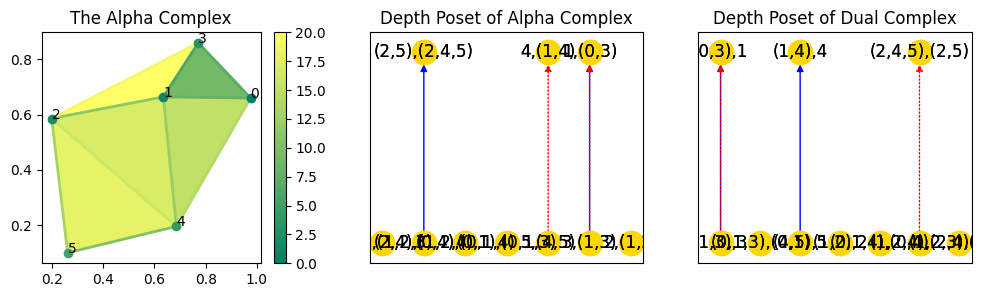

In [74]:
case = np.random.choice(pd.unique(df_complexes[df_complexes['dim'] <= 2]['case']))

points = df_complexes[(df_complexes['case'] == case)&(df_complexes['how'] == 'alpha')]['points'].values[0]
stree = df_complexes[(df_complexes['case'] == case)&(df_complexes['how'] == 'alpha')]['stree'].values[0]
dp_alpha = df_complexes[(df_complexes['case'] == case)&(df_complexes['how'] == 'alpha')]['dp0'].values[0]
dp_dual = df_complexes[(df_complexes['case'] == case)&(df_complexes['how'] == 'dual')]['dp0'].values[0]



fig, axs = plt.subplots(1, 3, figsize=(12, 3))

axs[0].set_title('The Alpha Complex')
sm = plot_filtred_complex2d(stree, points, cmap='summer', ax=axs[0])
plt.colorbar(sm, ax=axs[0])
enumerate_points(points, ax=axs[0])

axs[1].set_title('Depth Poset of Alpha Complex')
nx.draw_networkx(dp_alpha.get_column_bottom_to_top_reduction().get_transitive_reduction(), pos=dp_alpha.hasse_layout(), 
                 node_color='gold', edge_color='blue', style='-', ax=axs[1])
nx.draw_networkx(dp_alpha.get_row_left_to_right_reduction().get_transitive_reduction(), pos=dp_alpha.hasse_layout(), 
                 node_color='gold', edge_color='red', style=':', ax=axs[1])


axs[2].set_title('Depth Poset of Dual Complex')
nx.draw_networkx(dp_dual.get_column_bottom_to_top_reduction().get_transitive_reduction(), pos=dp_dual.hasse_layout(), 
                 node_color='gold', edge_color='blue', style='-', ax=axs[2])
nx.draw_networkx(dp_dual.get_row_left_to_right_reduction().get_transitive_reduction(), pos=dp_dual.hasse_layout(), 
                 node_color='gold', edge_color='red', style=':', ax=axs[2])

plt.show()

In [75]:
if False:
    dp_equality = []
    
    cases = pd.unique(df_complexes['case'])
    for case in tqdm(cases, total=len(cases)):
        dp_alpha = df_complexes[(df_complexes['case'] == case)&(df_complexes['how'] == 'alpha')]['dp0'].values[0]
        dp_dual = df_complexes[(df_complexes['case'] == case)&(df_complexes['how'] == 'dual')]['dp0'].values[0]
        
        graphs = {
            ('alpha', 'column reduction') : dp_alpha.get_column_bottom_to_top_reduction().get_transitive_reduction(), 
            ('alpha', 'row reduction') : dp_alpha.get_row_left_to_right_reduction().get_transitive_reduction(), 
            ('dual', 'column reduction') : dp_dual.get_column_bottom_to_top_reduction().get_transitive_reduction(), 
            ('dual', 'row reduction') : dp_dual.get_row_left_to_right_reduction().get_transitive_reduction(), 
        }
        res = {}
        for key0, key1 in itertools.combinations(graphs.keys(), 2):
            g0 = graphs[key0]
            g1 = graphs[key1]
            GM = nx.algorithms.isomorphism.DiGraphMatcher(g0, g1)
            res.update({(key0, key1): GM.is_isomorphic()})
        dp_equality.append(res)
        
    dp_equality = pd.DataFrame(dp_equality)
    print((dp_equality.mean(axis=0)*100).round(2).astype(str) +'%')

In [76]:
df_transpositions = []

for irow, row in tqdm(df_complexes.iterrows(), total=len(df_complexes)):
    
    dp, order, dims, border_matrix = row[['dp0', 'order', 'dims', 'matrix']]
    backward = row['how'] == 'dual'
    for transposition in iterate_possible_transpositions(dp, order=order, backward=backward):
        transposition['switch'] = get_switch_type(border_matrix, dp, transposition, order=order)
        df_transpositions.append(pd.concat([pd.Series({'complex': irow}), pd.Series(transposition)]))

df_transpositions = pd.DataFrame(df_transpositions)

print(f'df_transpositions.shape = {df_transpositions.shape}')
df_transpositions.head()

100%|███████████████████████████████████████| 128/128 [3:02:12<00:00, 85.41s/it]


df_transpositions.shape = (9822, 11)


,complex,index 0,index 1,value 0,value 1,simplex 0,simplex 1,dim 0,dim 1,type,switch
0,0,0,1,0.0,1.0,[0],[1],0,0,None,no switch
1,0,1,2,1.0,2.0,[1],[2],0,0,birth-birth,switch backward
2,0,2,3,2.0,3.0,[2],[3],0,0,birth-birth,no switch
3,0,3,4,3.0,4.0,[3],[4],0,0,birth-birth,no switch
4,0,4,5,4.0,5.0,[4],[5],0,0,birth-birth,no switch


In [77]:
df_transpositions[['type', 'switch']].value_counts().sort_index()

type         switch         
birth-birth  no switch          1533
             switch backward      96
             switch forward       95
birth-death  no switch          4470
             switch forward     1776
death-death  no switch          1533
             switch backward      96
             switch forward       95
Name: count, dtype: int64

In [78]:
def get_order_and_border_matrix_after_transposition(order0, border_matrix0, transposition):
    # 
    i0, i1 = transposition[['index 0', 'index 1']]
    order1 = np.array(order0, dtype=object)
    order1[[i0, i1]] = order1[[i1, i0]]
    border_matrix1 = border_matrix0.copy()
    border_matrix1[[i0, i1], :] = border_matrix1[[i1, i0], :]
    border_matrix1[:, [i0, i1]] = border_matrix1[:, [i1, i0]]

    return order1, border_matrix1

In [79]:
results = []
for i, transposition in tqdm(df_transpositions.iterrows(), total=len(df_transpositions)):
    # 
    complex_row = df_complexes.loc[transposition['complex']]
    order0, border_matrix0, dp0 = complex_row[['order', 'matrix', 'dp0']]
    order1, border_matrix1 = get_order_and_border_matrix_after_transposition(order0, border_matrix0, transposition)
    dims1 = [len(s) - 1 for s in order1]
    dp1 = DepthPoset.from_border_matrix(border_matrix1, dims1, sources=order1)
    
    results_i = {}
    for score in scores:
        param_names = inspect.signature(score).parameters.keys()
        args = {name: value for name, value in locals().items() if name in param_names}

        try:
            value = score(**args)
        except Exception as err:
            tr_type, tr_switch = transposition[['type', 'switch']]
            if (tr_type, tr_switch) == ('birth-birth', 'switch forward') and score in [jacard_l31a, jacard_l31b]:
                print(transposition)
                raise err
            if (tr_type, tr_switch) == ('death-death', 'switch forward') and score in [jacard_l32a, jacard_l32b]:
                print(transposition)
                raise err
            value = None
            
        results_i.update({score.__name__: value})
    results.append(results_i)
results = pd.DataFrame(results)



df_transpositions = df_transpositions[np.setdiff1d(df_transpositions.columns, results.columns)]
df_transpositions = df_transpositions.join(results)

print(f'df_transpositions.shape = {df_transpositions.shape}')
df_transpositions.head()

100%|█████████████████████████████████████| 9822/9822 [1:26:07<00:00,  1.90it/s]

df_transpositions.shape = (9822, 23)


,complex,dim 0,dim 1,index 0,index 1,simplex 0,simplex 1,switch,type,value 0,...,jacard_edges_filtration,jacard_edges_simplex,jacard_l31a,jacard_l31b,jacard_l32a,jacard_l32b,jacard_l33a,jacard_l33b,jacard_nn_nodes,jacard_nn_edges
0,0,0,0,0,1,[0],[1],no switch,None,0.0,...,0.500000,0.2,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0
1,0,0,0,1,2,[1],[2],switch backward,birth-birth,1.0,...,0.600000,0.0,0.0,1.0,0.0,1.0,NaN,NaN,1.0,1.0
2,0,0,0,2,3,[2],[3],no switch,birth-birth,2.0,...,0.333333,0.6,NaN,NaN,NaN,1.0,NaN,NaN,1.0,1.0
3,0,0,0,3,4,[3],[4],no switch,birth-birth,3.0,...,0.333333,1.0,NaN,NaN,NaN,1.0,NaN,NaN,1.0,1.0
4,0,0,0,4,5,[4],[5],no switch,birth-birth,4.0,...,0.333333,1.0,NaN,NaN,NaN,1.0,NaN,NaN,1.0,1.0


In [80]:
result_bb = df_transpositions[(df_transpositions['type'] == 'birth-birth')&(df_transpositions['switch'] == 'switch forward')]
result_bb = result_bb.join(df_complexes, on='complex', lsuffix='', rsuffix='_right')[['case', 'complex', 'n', 'dim', 'how', 
                                                                                      'type', 'switch', 'simplex 0', 'simplex 1', 
                                                                                      'jacard_l31a', 'jacard_l31b']]

for score_col in ['jacard_l31a', 'jacard_l31b']:
    vals = pd.unique(result_bb[score_col])
    vals = vals[vals != 1]
    print(f'There are {(result_bb[score_col] != 1).sum()} unexpected values for {score_col}: {vals}')
print()

print(f'result_bb.shape = {result_bb.shape}')
result_bb.head()
result_bb[(result_bb['jacard_l31a'] != 1)|(result_bb['jacard_l31b'] != 1)]

There are 0 unexpected values for jacard_l31a: []
There are 0 unexpected values for jacard_l31b: []

result_bb.shape = (95, 11)


,case,complex,n,dim,how,type,switch,simplex 0,simplex 1,jacard_l31a,jacard_l31b


In [81]:
result_dd = df_transpositions[(df_transpositions['type'] == 'death-death')&(df_transpositions['switch'] == 'switch forward')]
#result_dd = result_dd.join(df_complexes, on='complex')[['case', 'n', 'dim', 'how', 'simplex 0', 'simplex 1', 'jacard_l32a', 'jacard_l32b']]
result_dd = result_dd.join(df_complexes, on='complex', lsuffix='', rsuffix='_right')[['case', 'complex', 'n', 'dim', 'how', 
                                                                                      'type', 'switch', 'simplex 0', 'simplex 1', 
                                                                                      'jacard_l32a', 'jacard_l32b']]

for score_col in ['jacard_l32a', 'jacard_l32b']:
    vals = pd.unique(result_dd[score_col])
    vals = vals[vals != 1]
    print(f'There are {(result_dd[score_col] != 1).sum()} unexpected values for {score_col}: {vals}')
print()

print(f'result_dd.shape = {result_dd.shape}')
#result_dd.head()
result_dd[(result_dd['jacard_l32a'] != 1)|(result_dd['jacard_l32b'] != 1)]

There are 0 unexpected values for jacard_l32a: []
There are 0 unexpected values for jacard_l32b: []

result_dd.shape = (95, 11)


,case,complex,n,dim,how,type,switch,simplex 0,simplex 1,jacard_l32a,jacard_l32b


In [82]:
result_bd = df_transpositions[(df_transpositions['type'] == 'birth-death')&(df_transpositions['switch'] == 'switch forward')]
#result_bd = result_bd.join(df_complexes, on='complex')[['case', 'n', 'dim', 'how', 'simplex 0', 'simplex 1', 'jacard_l33a', 'jacard_l33b']]
result_bd = result_bd.join(df_complexes, on='complex', lsuffix='', rsuffix='_right')[['case', 'complex', 'n', 'dim', 'how', 
                                                                                      'type', 'switch', 'simplex 0', 'simplex 1', 
                                                                                      'jacard_l33a', 'jacard_l33b']]


for score_col in ['jacard_l33a', 'jacard_l33b']:
    vals = pd.unique(result_bd[score_col])
    vals = vals[vals != 1]
    print(f'There are {(result_bd[score_col] != 1).sum()} unexpected values for {score_col}: {vals}')
print()

print(f'result_bd.shape = {result_bd.shape}')
result_bd.head()

There are 0 unexpected values for jacard_l33a: []
There are 0 unexpected values for jacard_l33b: []

result_bd.shape = (1776, 11)


,case,complex,n,dim,how,type,switch,simplex 0,simplex 1,jacard_l33a,jacard_l33b
7,1,0,6,2,alpha,birth-death,switch forward,"[1, 3]","[3, 4]",1.0,1.0
11,1,0,6,2,alpha,birth-death,switch forward,"[0, 2]","[0, 3]",1.0,1.0
20,1,1,6,2,dual,birth-death,switch forward,"[0, 3]","[0, 2]",1.0,1.0
24,1,1,6,2,dual,birth-death,switch forward,"[3, 4]","[1, 3]",1.0,1.0
70,3,4,6,2,alpha,birth-death,switch forward,"[1, 2]","[1, 4]",1.0,1.0


__Comment:__ There is some issue with `jacard_l31b` and `jacard_l32b` scores: they should not return NaN values for given transpositions.

In [83]:
result_nn = df_transpositions.join(df_complexes, on='complex', lsuffix='', rsuffix='_right')
#result_nn = result_nn[['case', 'complex', 'n', 'dim', 'how', 'simplex 0', 'simplex 1', 'jacard_nn_nodes', 'jacard_nn_edges']]
result_nn = result_nn.join(df_complexes, on='complex', lsuffix='', rsuffix='_right')[['case', 'complex', 'n', 'dim', 'how', 
                                                                                      'type', 'switch', 'simplex 0', 'simplex 1', 
                                                                                      'jacard_nn_nodes', 'jacard_nn_edges']]


#df_nn[['jacard_nn_nodes', 'jacard_nn_edges']].astype(str).value_counts()

for score_col in ['jacard_nn_nodes', 'jacard_nn_edges']:
    vals = pd.unique(result_nn[score_col])
    vals = vals[vals != 1]
    print(f'There are {(result_nn[score_col] != 1).sum()} unexpected values for {score_col}: {vals}')
print()

print(f'result_nn.shape = {result_nn.shape}')
#result_nn.head()
result_nn[(result_nn['jacard_nn_nodes'] != 1)|(result_nn['jacard_nn_edges'] != 1)]

There are 0 unexpected values for jacard_nn_nodes: []
There are 0 unexpected values for jacard_nn_edges: []

result_nn.shape = (9822, 11)


,case,complex,n,dim,how,type,switch,simplex 0,simplex 1,jacard_nn_nodes,jacard_nn_edges


# Raporting

## Problems

In [84]:
# load problems description
with open('texts/transpositions - porblems.tex', 'r') as file:
    s_problems = file.read()

## Model and Experiments

In [85]:
# load model description
with open('texts/transpositions - model.tex', 'r') as file:
    s_model_descr = file.read()

In [86]:
df_transpositions[['complex', 'type', 'switch']].value_counts().sort_index()

complex  type         switch         
0        birth-birth  no switch            3
                      switch backward      1
         birth-death  no switch            5
                      switch forward       2
         death-death  no switch            4
                                        ... 
127      birth-death  no switch          157
                      switch forward      83
         death-death  no switch           40
                      switch backward      1
                      switch forward       4
Name: count, Length: 776, dtype: int64

In [87]:
df_complex_types = df_transpositions[['complex', 'type', 'switch']].value_counts().reset_index()
df_complex_types = df_complex_types.sort_values(by=['complex', 'type', 'switch']).rename(columns={0: 'count'})
df_complex_types = pd.pivot_table(df_complex_types, index='complex', columns=['switch', 'type'], values='count').fillna(0).astype(int)
df_complex_types = df_complex_types[[('switch forward', 'birth-birth'), 
                                     ('switch forward', 'death-death'), 
                                     ('switch forward', 'birth-death'), 
                                     ('switch backward', 'birth-birth'), 
                                     ('switch backward', 'death-death'), 
                                     ('no switch', 'birth-birth'), 
                                     ('no switch', 'death-death'), 
                                     ('no switch', 'birth-death'), ]]
#df_complex_types.columns.names = ['', 'type']
df_complex_types.columns.names = ['', '']

df_complex_types.loc['Total'] = df_complex_types.sum()
df_complex_types = pd.concat([df_complex_types.iloc[-1:], df_complex_types.iloc[:-1]])

print(f'df_complex_types.shape = {df_complex_types.shape}')

df_complex_types.head()

df_complex_types.shape = (129, 8)


switch forward                         switch backward              \
           birth-birth death-death birth-death     birth-birth death-death   
complex                                                                      
Total               95          95        1776              96          96   
0                    0           0           2               1           0   
1                    0           0           2               0           1   
2                    0           1           0               1           0   
3                    1           0           0               0           1   

          no switch                          
        birth-birth death-death birth-death  
complex                                      
Total          1533        1533        4470  
0                 3           4           5  
1                 4           3           5  
2                 3           3           6  
3                 3           3           6

In [88]:
df_complexes_descr = df_complexes
df_complexes_descr['complex'] = df_complexes.index.astype(int)
df_complexes_descr = df_complexes_descr

df_complexes_descr = pd.pivot_table(df_complexes_descr, index=['case', 'n', 'dim'], columns='how', values='complex')
df_complexes_descr[['alpha', 'dual']] = df_complexes_descr[['alpha', 'dual']].astype(int)
df_complexes_descr.columns = df_complexes_descr.columns.rename('complex')

print(f'df_complexes_descr.shape = {df_complexes_descr.shape}')
df_complexes_descr.head()

df_complexes_descr.shape = (64, 2)


,,complex,alpha,dual
case,n,dim,,
1,6,2,0,1
2,6,2,2,3
3,6,2,4,5
4,6,2,6,7
5,6,2,8,9


In [89]:
replace_colname_dict = {'birth-birth': r'\makecell{birth-\\birth}', 
                        'birth-death': r'\makecell{birth-\\death}', 
                        'death-death': r'\makecell{death-\\death}',}
def replace_colname(s):
    for key, value in replace_colname_dict.items():
        s = s.replace(key, value)
    return s

In [107]:
s_model_and_experiments = f"""
{s_model_descr}

\\par We can see the calculated cases in the table the given:
\\begin{{center}}
{df_complexes_descr.iloc[:len(df_complexes_descr)//2].to_latex()}{df_complexes_descr.iloc[len(df_complexes_descr)//2:].to_latex()}
\\end{{center}}

\\par We can see the distribution of transposition types in each complex in the given table:
\\begin{{center}}
{'\n'.join([replace_colname(df_complex_types.iloc[i:i+35].to_latex()) for i in range(0, len(df_complex_types), 35)])}
\\end{{center}}

"""

## Scores Desctiption

In [114]:
s_scores = ''

for score in scores:
    s_scores += f'''
    \\par \\textbf{{{score.__name__.replace('_', r'\_')}}} - {score.__doc__}
    '''

## Unexpected Results

### Ploting Images

In [91]:
examples_number_lemmas = 2
examples_number_hypothesis = 1

drow_indices = []

for col in ['jacard_l31a', 'jacard_l31b']:
    draw_col = df_transpositions[(df_transpositions['switch'] == 'switch forward')&(df_transpositions['type'] == 'birth-birth')][col]
    draw_col = draw_col[draw_col != 1].astype(str)
    for val in pd.unique(draw_col):
        drow_indices.append(draw_col[draw_col == val].index[:examples_number_lemmas])
        
for col in ['jacard_l32a', 'jacard_l32b']:
    draw_col = df_transpositions[(df_transpositions['switch'] == 'switch forward')&(df_transpositions['type'] == 'death-death')][col]
    draw_col = draw_col[draw_col != 1].astype(str)
    for val in pd.unique(draw_col):
        drow_indices.append(draw_col[draw_col == val].index[:examples_number_lemmas])
        
for col in ['jacard_l33a', 'jacard_l33b']:
    draw_col = df_transpositions[(df_transpositions['switch'] == 'switch forward')&(df_transpositions['type'] == 'birth-death')][col]
    draw_col = draw_col[draw_col != 1].astype(str)
    for val in pd.unique(draw_col):
        drow_indices.append(draw_col[draw_col == val].index[:examples_number_lemmas])
        
for col in ['jacard_nn_nodes', 'jacard_nn_edges']:
    draw_col = df_transpositions[col]
    draw_col = draw_col[draw_col != 1].astype(str)
    for val in pd.unique(draw_col):
        drow_indices.append(draw_col[draw_col == val].index[:examples_number_hypothesis])

if drow_indices != []:
    drow_indices = np.unique(np.concatenate(drow_indices))

# remove nonplanar complexes
planar_complexes = df_complexes[df_complexes['dim'] <= 2].index
drow_indices = df_transpositions.loc[drow_indices]
drow_indices = drow_indices[drow_indices['complex'].isin(planar_complexes)].index

drow_indices

Index([], dtype='int64')

In [92]:
df_drow = df_transpositions.loc[drow_indices].merge(df_complexes, left_on='complex', right_index=True, how='left')

print(f'df_drow.shape = {df_drow.shape}')
df_drow

df_drow.shape = (0, 35)


,complex,complex_x,dim 0,dim 1,index 0,index 1,simplex 0,simplex 1,switch,type,...,n,dim,how,matrix,order,dims,points,stree,dp0,complex_y


In [93]:
transposition_image_output_format = 'raports/pics/transposition{0}.png'

show = False

for irow, row in tqdm(df_drow.iterrows(), total=len(df_drow)):
    i0, i1 = row[['index 0', 'index 1']]
    s0, s1 = row[['simplex 0', 'simplex 1']]
    
    simplex0 = tuple([int(i) for i in row['simplex 0']])
    simplex1 = tuple([int(i) for i in row['simplex 1']])
    
    border_matrix0, order0, dp0 = row[['matrix', 'order', 'dp0']]
    dims0 = np.array([len(s) - 1 for s in order0])
    
    x, y, a, b = get_xyab(row, dp0)
    
    order1, border_matrix1 = get_order_and_border_matrix_after_transposition(order0, border_matrix0, row)
    dims1 = [len(s) - 1 for s in order1]
    dp1 = DepthPoset.from_border_matrix(border_matrix1, dims1, sources=order1)
    
    
    
    breaking_lemma31 = (row[['jacard_l31a', 'jacard_l31b']] != 1).any() and (row['type'] == 'birth-birth') and (row['switch'] == 'switch forward')
    breaking_lemma32 = (row[['jacard_l32a', 'jacard_l32b']] != 1).any() and (row['type'] == 'death-death') and (row['switch'] == 'switch forward')
    breaking_lemma33 = (row[['jacard_l33a', 'jacard_l33b']] != 1).any() and (row['type'] == 'birth-death') and (row['switch'] == 'switch forward')
    breaking_hypothesis = (row[['jacard_nn_nodes', 'jacard_nn_edges']] != 1).any()
    
    # geting the Alpha Simplex
    if row['how'] == 'alpha':
        cloud_title = 'Alpha Complex'
        stree, points = row[['stree', 'points']]
    else:
        new_row = df_complexes[(df_complexes['case'] == row['case'])&(df_complexes['how'] == 'alpha')].iloc[0]
        cloud_title = 'Original Alpha Complex'
        stree, points = new_row[['stree', 'points']]
        
    transposition_type = row['type'].title()
    transposition_switch = row['switch'].title().replace(' ', '-')
    title = f"The {transposition_type} {transposition_switch} Transposition\nof Simplices {simplex0} and {simplex1} in {row['how'].title()} Complex {row['complex']}"
    
    fig, axs = plt.subplots(3, 2, figsize=(9, 12))
    fig.suptitle(title, fontsize=18)
    
    # Drawing the Alpha Simplex
    axs[0, 0].set_title(cloud_title)
    sm = plot_filtred_complex2d(stree, points, ax=axs[0, 0], cmap='summer')
    plt.colorbar(sm, ax=axs[0, 0])
    plot_simplex(s0, points, ax=axs[0, 0], color='red', marker='*', linestyle=':', hatch='+', 
                 label=f'f({simplex0}) = {stree.filtration(s0)}', zorder=4)
    plot_simplex(s1, points, ax=axs[0, 0], color='blue', marker='*', linestyle=':', hatch='+', 
                 label=f'f({simplex1}) = {stree.filtration(s1)}', zorder=4)
    enumerate_points(points, ax=axs[0, 0])
    axs[0, 0].legend()
    
    
    # show an original border matrix
    delta_to_plot = border_matrix0.copy().astype(float)
    delta_to_plot[delta_to_plot == 0] = np.nan
    delta_to_plot = dims0*delta_to_plot
    
    if transposition['type'] == 'birth-death':
        xticks = np.sort([x, y, a, b])
        yticks = np.sort([x, y, a, b])
    else:
        xticks = np.sort([y, b])
        yticks = np.sort([x, a])
    
    # plot border matrix
    axs[0, 1].set_title('The Border Matrix')
    axs[0, 1].imshow(delta_to_plot, cmap='jet', vmin=0.75, vmax=dims0.max())
    axs[0, 1].set_xticks(xticks, labels=order0[xticks], rotation=90)
    axs[0, 1].set_yticks(yticks, labels=order0[yticks], rotation=0)
    axs[0, 1].grid(True)
    
    
    # plot reducted matrices
    stop_condition = lambda alpha, b0, delta: len({(a, b), (a, y), (x, b), (x, y)} & set(alpha.values())) + \
                                              len({(a, x), (x, a), (b, y), (y, b)} & set(b0)) > 0
    if breaking_lemma31:
        alpha, b0, delta0 = depth.reduct_column_bottom_to_top(border_matrix0, stop_condition)
        alpha, b0, delta1 = depth.reduct_column_bottom_to_top(border_matrix1, stop_condition)
        axs[1, 0].set_title(f'Column Reduction before the Transposition')
        axs[1, 1].set_title(f'Column Reduction after the Transposition')
    elif breaking_lemma32:
        omega, b1, delta0 = depth.reduct_row_left_to_right(border_matrix0, stop_condition)
        omega, b1, delta1 = depth.reduct_row_left_to_right(border_matrix1, stop_condition)
        axs[1, 0].set_title(f'Row Reduction before the Transposition')
        axs[1, 1].set_title(f'Row Reduction after the Transposition')
    else:
        alpha, b0, delta0 = depth.reduct_column_bottom_to_top(border_matrix0, stop_condition)
        omega, b1, delta0 = depth.reduct_row_left_to_right(delta0, stop_condition)
        alpha, b0, delta1 = depth.reduct_column_bottom_to_top(border_matrix1, stop_condition)
        omega, b1, delta1 = depth.reduct_row_left_to_right(delta1, stop_condition)
        axs[1, 0].set_title(f'Reduction Matrix before the Transposition')
        axs[1, 1].set_title(f'Reduction Matrix after the Transposition')
    for i, (deltai, dimsi, orderi) in enumerate([(delta0, dims0, order0), (delta1, dims1, order1)]):
        deltai = deltai.astype(float)
        deltai[deltai == 0] = np.nan
        deltai = dimsi*deltai
        font_matrix = np.ones(deltai.shape)
        font_matrix[np.isnan(deltai).all(axis=1), :] = 0
        font_matrix[:, np.isnan(deltai).all(axis=0)] = 0
        axs[1, i].imshow(font_matrix, cmap='bone', vmin=-9)
        axs[1, i].imshow(deltai, cmap='jet', vmin=0.75, vmax=np.max(dimsi))
        axs[1, i].set_xticks(xticks, labels=orderi[xticks], rotation=90)
        axs[1, i].set_yticks(yticks, labels=orderi[yticks], rotation=0)
        axs[1, i].grid(True)
    
    
    # Ploting Depth Posets
    if breaking_lemma31 and not breaking_hypothesis:
        assert len(s0) == len(s1)
        poset_dim = len(s1) - 1
        dp0_to_plot = dp0.subposet_dim(poset_dim)
        dp1_to_plot = dp1.subposet_dim(poset_dim)
        axs[2, 0].set_title(f'Depth Subposet dim={poset_dim}\nbefore the Transposition')
        axs[2, 1].set_title(f'Depth Subposet dim={len(s1) - 1}\nafter the Transposition')
    elif breaking_lemma32 and not breaking_hypothesis:
        assert len(s0) == len(s1)
        poset_dim = len(s1) - 2
        dp0_to_plot = dp0.subposet_dim(poset_dim)
        dp1_to_plot = dp1.subposet_dim(poset_dim)
        axs[2, 0].set_title(f'Depth Subposet dim={poset_dim}\nbefore the Transposition')
        axs[2, 1].set_title(f'Depth Subposet dim={poset_dim}\nafter the Transposition')
    else:
        dp0_to_plot = dp0
        dp1_to_plot = dp1
        axs[2, 0].set_title(f'Depth Poset\nbefore the Transposition')
        axs[2, 1].set_title(f'Depth Poset\nafter the Transposition')
    
    set_edges_0 = exclude_transposition_from_edges(dp0_to_plot.get_transitive_reduction().edges, s0, s1)
    set_edges_1 = exclude_transposition_from_edges(dp1_to_plot.get_transitive_reduction().edges, s0, s1)
    set_edges_diff = set(set_edges_0).symmetric_difference(set_edges_1)
    graph_missed = nx.Graph()
    graph_missed.add_edges_from(set_edges_diff)

    # Create custom legend handles
    legend_patches = [
        mlines.Line2D([], [], color='blue', linestyle='-', linewidth=1, label='Column Reduction'),
        mlines.Line2D([], [], color='red', linestyle=':', linewidth=1, label='Row Reduction'),
    ]
    if len(set_edges_diff) != 0:
        legend_patches.append(mlines.Line2D([], [], color='springgreen', linestyle='-', linewidth=4, label='Missed Edge'))
    
    for i, dpi in enumerate([dp0_to_plot, dp1_to_plot]):
        nx.draw_networkx(graph_missed, pos=dpi.hasse_layout(), 
                         node_color='gold', edge_color='springgreen', style='-', width=4, ax=axs[2, i])
        nx.draw_networkx(dpi.get_column_bottom_to_top_reduction().get_transitive_reduction(), pos=dpi.hasse_layout(), 
                         node_color='gold', edge_color='blue', style='-', ax=axs[2, i])
        nx.draw_networkx(dpi.get_row_left_to_right_reduction().get_transitive_reduction(), pos=dpi.hasse_layout(), 
                         node_color='gold', edge_color='red', style=':', ax=axs[2, i])
        axs[2, i].legend(handles=legend_patches)
    plt.tight_layout()
    
    plt.savefig(transposition_image_output_format.format(irow))
    if show:
        plt.show()
        show = False
    plt.close()

0it [00:00, ?it/s]


### Lemma 3.1

In [94]:
result_bb_table = result_bb[(result_bb[['jacard_l31a', 'jacard_l31b']] != 1).any(axis=1)]
bb_drown_indices = np.intersect1d(result_bb_table.index, df_drow.index)

result_bb_table['Figure'] = ''
result_bb_table.loc[bb_drown_indices, 'Figure'] = [f'Figure \\ref{{fig:unexpected{i}}}' for i in bb_drown_indices]

for col in ['simplex 0', 'simplex 1']:
    result_bb_table[col] = [tuple([int(v) for v in s]) for s in result_bb_table[col]]

result_bb_table = result_bb_table[['case', 'complex', 'simplex 0', 'simplex 1', 'jacard_l31a', 'jacard_l31b', 'Figure']]
result_bb_table = result_bb_table.rename(columns={col: col.replace('_', r'\_') for col in result_bb_table.columns})
result_bb_table

,case,complex,simplex 0,simplex 1,jacard\_l31a,jacard\_l31b,Figure


In [95]:
s_unexpected_lemma31 = f"""
\\par Lemma 3.1 can be measured by 2 scores: \\textbf{{jacard\\_l31a}} and \\textbf{{jacard\\_l31b}}. 
And there are {len(result_bb_table)} of {len(result_bb)} switch-forward birth-birth transpositions found where these scores are not 1.
"""

if len(result_bb_table) != 0:
    s_unexpected_lemma31 += '\\par We can see these situations in the table:\n'
    s_unexpected_lemma31 += r'\begin{center}'
    s_unexpected_lemma31 += '\n'.join([result_bb_table.iloc[i: i+40].to_latex(index=False, float_format='%.2f') for i in range(0, len(result_bb_table), 40)])
    s_unexpected_lemma31 += r'\end{center}'
    
print(s_unexpected_lemma31)


\par Lemma 3.1 can be measured by 2 scores: \textbf{jacard\_l31a} and \textbf{jacard\_l31b}. 
And there are 0 of 95 switch-forward birth-birth transpositions found where these scores are not 1.



### Lemma 3.2

In [96]:
result_dd_table = result_dd[(result_dd[['jacard_l32a', 'jacard_l32b']] != 1).any(axis=1)]
dd_drown_indices = np.intersect1d(result_dd_table.index, df_drow.index)

result_dd_table['Figure'] = ''
result_dd_table.loc[dd_drown_indices, 'Figure'] = [f'Figure \\ref{{fig:unexpected{i}}}' for i in dd_drown_indices]

for col in ['simplex 0', 'simplex 1']:
    result_dd_table[col] = [tuple([int(v) for v in s]) for s in result_dd_table[col]]

result_dd_table = result_dd_table[['case', 'complex', 'simplex 0', 'simplex 1', 'jacard_l32a', 'jacard_l32b', 'Figure']]
result_dd_table = result_dd_table.rename(columns={col: col.replace('_', r'\_') for col in result_dd_table.columns})
result_dd_table

,case,complex,simplex 0,simplex 1,jacard\_l32a,jacard\_l32b,Figure


In [97]:
s_unexpected_lemma32 = f"""
\\par Lemma 3.2 can be measured by 2 scores: \\textbf{{jacard\\_l32a}} and \\textbf{{jacard\\_l32b}}. 
And there are {len(result_dd_table)} of {len(result_dd)} switch-forward death-death transpositions found where these scores are not 1.
"""

if len(result_dd_table) != 0:
    s_unexpected_lemma32 += '\\par We can see these situations in the table:\n'
    s_unexpected_lemma32 += r'\begin{center}'
    s_unexpected_lemma32 += '\n'.join([result_dd_table.iloc[i: i+40].to_latex(index=False, float_format='%.2f') for i in range(0, len(result_dd_table), 40)])
    s_unexpected_lemma32 += r'\end{center}'
    

print(s_unexpected_lemma32)


\par Lemma 3.2 can be measured by 2 scores: \textbf{jacard\_l32a} and \textbf{jacard\_l32b}. 
And there are 0 of 95 switch-forward death-death transpositions found where these scores are not 1.



### Lemma 3.3

In [98]:
result_bd_table = result_bd[(result_bd[['jacard_l33a', 'jacard_l33b']] != 1).any(axis=1)]
bd_drown_indices = np.intersect1d(result_bd_table.index, df_drow.index)

result_bd_table['Figure'] = ''
result_bd_table.loc[bd_drown_indices, 'Figure'] = [f'Figure \\ref{{fig:unexpected{i}}}' for i in bd_drown_indices]

for col in ['simplex 0', 'simplex 1']:
    result_bd_table[col] = [tuple([int(v) for v in s]) for s in result_bd_table[col]]

result_bd_table = result_bd_table[['case', 'complex', 'simplex 0', 'simplex 1', 'jacard_l33a', 'jacard_l33b', 'Figure']]
result_bd_table = result_bd_table.rename(columns={col: col.replace('_', r'\_') for col in result_bd_table.columns})
result_bd_table

,case,complex,simplex 0,simplex 1,jacard\_l33a,jacard\_l33b,Figure


In [99]:
s_unexpected_lemma33 = f"""
\\par Lemma 3.3 can be measured by 2 scores: \\textbf{{jacard\\_l33a}} and \\textbf{{jacard\\_l33b}}. 
And there are {len(result_bd_table)} of {len(result_bd)} switch-forward birth-death transpositions found where these scores are not 1.
"""

if len(result_bd_table) != 0:
    s_unexpected_lemma33 += '\\par We can see these situations in the table:\n'
    s_unexpected_lemma33 += r'\begin{center}'
    s_unexpected_lemma33 += '\n'.join([result_bd_table.iloc[i: i+40].to_latex(index=False, float_format='%.2f') for i in range(0, len(result_bd_table), 40)])
    s_unexpected_lemma33 += r'\end{center}'
    
print(s_unexpected_lemma33)


\par Lemma 3.3 can be measured by 2 scores: \textbf{jacard\_l33a} and \textbf{jacard\_l33b}. 
And there are 0 of 1776 switch-forward birth-death transpositions found where these scores are not 1.



### Hypothesis

In [100]:
result_nn_table = result_nn[(result_nn[['jacard_nn_nodes', 'jacard_nn_edges']] != 1).any(axis=1)]
nn_drown_indices = np.intersect1d(result_nn_table.index, df_drow.index)

result_nn_table['Figure'] = ''
result_nn_table.loc[nn_drown_indices, 'Figure'] = [f'Figure \\ref{{fig:unexpected{i}}}' for i in nn_drown_indices]


for col in ['simplex 0', 'simplex 1']:
    result_nn_table[col] = [tuple([int(v) for v in s]) for s in result_nn_table[col]]


result_nn_table = result_nn_table[['case', 'complex', 'simplex 0', 'simplex 1', 'jacard_nn_nodes', 'jacard_nn_edges', 'Figure']]
result_nn_table = result_nn_table.rename(columns={col: col.replace('_', r'\_') for col in result_nn_table.columns})
result_nn_table

,case,complex,simplex 0,simplex 1,jacard\_nn\_nodes,jacard\_nn\_edges,Figure


In [101]:
s_unexpected_hypothesis = f"""
\\par The Hypothesis can be measured by 2 scores: \\textbf{{jacard\\_nn\\_nodes}} and \\textbf{{jacard\\_nn\\_edges}}. 
And there are {len(result_nn_table)} of {len(result_nn)} transpositions found where these scores are not 1.
"""

if len(result_nn_table) != 0:
    s_unexpected_hypothesis += '\\par We can see these situations in the table:\n'
    s_unexpected_hypothesis += r'\begin{center}'
    s_unexpected_hypothesis += '\n'.join([result_nn_table.iloc[i: i+40].to_latex(index=False, float_format='%.2f') for i in range(0, len(result_nn_table), 40)])
    s_unexpected_hypothesis += r'\end{center}'
    
print(s_unexpected_hypothesis)


\par The Hypothesis can be measured by 2 scores: \textbf{jacard\_nn\_nodes} and \textbf{jacard\_nn\_edges}. 
And there are 0 of 9822 transpositions found where these scores are not 1.



### Pasting Images

In [102]:
print('transposition_image_output_format:', transposition_image_output_format)

transposition_image_output_format_truncated = transposition_image_output_format.replace('raports/', '')
print('transposition_image_output_format_truncated:', transposition_image_output_format_truncated)

s_unexpected_pictures = ''

for i, row in df_drow.iterrows():
    tr_type = row['type']
    s0 = tuple([int(v) for v in row['simplex 0']])
    s1 = tuple([int(v) for v in row['simplex 1']])

    s_unexpected_pictures += f"""
        \\begin{{figure}}[ht]
        \\centering
        \\includegraphics[width=\\textwidth]{{{transposition_image_output_format_truncated.format(i)}}}
        \\caption{{The {tr_type} Transposition of simplices {s0} and {s1} in complex {row['complex']}}}
        \\label{{fig:unexpected{i}}}
        \\end{{figure}}
    """

transposition_image_output_format: raports/pics/transposition{0}.png
transposition_image_output_format_truncated: pics/transposition{0}.png


## Gathering the final LaTeX Document and generating PDF

In [103]:
# load LaTeX template
with open('texts/template.tex', 'r') as file:
    s_latex = file.read()

In [108]:
body = f"""
\\section{{Problems}}
{s_problems}

\\section{{Model and Experiments}}
{s_model_and_experiments}

\\section{{scores}}
{}

\\section{{Conclusions and Unexpected Cases}}
\\subsection{{Lemma 3.1}}
{s_unexpected_lemma31}
\\subsection{{Lemma 3.2}}
{s_unexpected_lemma32}
\\subsection{{Lemma 3.3}}
{s_unexpected_lemma33}
\\subsection{{Hypothesis}}
{s_unexpected_hypothesis}

{s_unexpected_pictures}

"""

raport = s_latex.replace('BODY', body)
raport = '\n'.join([s.strip() for s in raport.split('\n')])

#print(raport)


In [109]:
with open('raports/transpositions.tex', 'w') as file:
    file.write(raport)

In [110]:
%cd raports
os.system('pdflatex transpositions.tex')
%cd ..

/home/feodor/Jupyter/depth-poset/raports
This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023/Debian) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode
(./transpositions.tex
LaTeX2e <2023-11-01> patch level 1
L3 programming layer <2024-01-22>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2023/05/17 v1.4n Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/amsfonts/amsfonts.sty)
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amsmath.sty
For additional information on amsmath, use the `?' option.
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amstext.sty
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amsgen.sty))
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amsbsy.sty)
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amsopn.sty))
(/usr/share/texlive/texmf-dist/tex/latex/hyperref/hyperref.sty
(/usr/share/texlive/texmf-dist/tex/